# GLMsingle: single-trial estimation in rapid event-related design

This notebook is my attempt at applying the new GLMsingle toolbox to the SVD dataset. I am starting with the tutorial provided on the GLMsingle GitHub and modifying it for the SVD dataset. (LM)
https://htmlpreview.github.io/?https://github.com/kendrickkay/GLMsingle/blob/main/examples/example1.html   

By default, the tool implements a set of optimizations that improve upon generic GLM approaches by: (1) identifying an optimal hemodynamic response function (HRF) at each voxel, (2) deriving a set of useful GLM nuisance regressors via "GLMdenoise" and picking an optimal number to include in the final GLM, and (3) applying a custom amount of ridge regularization at each voxel using an efficient technique called "fracridge". The output of GLMsingle are GLM betas reflecting the estimated percent signal change in each voxel in response to each experimental stimulus or condition being modeled.

Example 1 contains a full walkthrough of the process of loading an example dataset and design matrix, estimating neural responses using GLMsingle, estimating the reliability of responses at each voxel, and comparing those achieved via GLMsingle to those achieved using a baseline GLM. After loading and visualizing formatted fMRI time-series and their corresponding design matrices, we will describe the default behavior of GLMsingle and show how to modify hyperparameters if the user desires. Throughout the notebook we will highlight important metrics and outputs using figures, print statements, and comments.

## A note about conda environments

When running this notebook, make sure you have activated the mindeye conda environment.

## Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel import imagestats
import nilearn
from nilearn.input_data import NiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from os.path import join, exists, split
import sys
import ast
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')
import h5py

sys.path.insert(0, '/mnt/cup/labs/norman/rsiyer/rtmindeye/code/analysis')  # used if running this as a notebook or script from a directory that doesn't include tseriesinterp
from tseriesinterp import tseriesinterp, reshape2D

import utils

# !pip install git+https://github.com/cvnlab/GLMsingle.git
# import glmsingle
from glmsingle.glmsingle import GLM_single

%matplotlib inline
# %autosave 5
#sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

In [2]:
def str2bool(value):
    return str(value).lower() in ("true", "1", "yes")

## Define settings

What subject and session do you want to run? 

In [3]:
def str_to_list(x):
    """Convert a comma-separated string to a list, or return the input if it's already a list."""
    if isinstance(x, str):
        return [item for item in x.split(',') if item.strip()]
    return x

def get_flag(name, default, cast=int):
    """Retrieve a flag from environment variables or return a default value."""
    if utils.is_interactive():
        return default
    val = os.environ.get(name.upper(), str(default))
    try:
        return cast(val)
    except Exception:
        return val

# Define all key settings using get_flag, which handles both interactive and non-interactive modes
sub = get_flag('SUB', 'sub-005', cast=str)
session = get_flag('SESSION', 'ses-06', cast=str)  # 'ses-xx', 'all'
func_task_name = get_flag('FUNC_TASK_NAME', 'C', cast=str)  # 'study' or 'A'; used to search for functional run in bids format
task=f'task-{func_task_name}_' if func_task_name != 'study' else ''
resample_voxel_size = get_flag('RESAMPLE_VOXEL_SIZE', False, cast=bool)

# settings for multiple sessions
ses_list_env = os.environ.get('SES_LIST', None)
if ses_list_env is not None and ses_list_env.strip() != "":
    assert session == "all", "If SES_LIST is set, session must be 'all'"
    ses_list = [item for item in ses_list_env.split(',') if item.strip()]
else:
    ses_list = [session]

design_ses_list_env = os.environ.get('DESIGN_SES_LIST', None)
if design_ses_list_env is not None and design_ses_list_env.strip() != "":
    design_ses_list = [item for item in design_ses_list_env.split(',') if item.strip()]
else:
    design_ses_list = ses_list

session_label = utils.get_session_label(ses_list)

ref_session = get_flag('REF_SESSION', 'ses-01', cast=str)  # None or 'ses-xx'; use the T1 from the reference session; use this only if the current session doesn't have a T1

if utils.is_interactive():
    if sub in ('sub-004', 'sub-005', 'sub-006'):
        homedir = f'/jukebox/norman/rsiyer/rtmindeye/data_{sub}/bids'
    else:
        homedir = f'/jukebox/norman/rsiyer/rtmindeye/data_{sub}_{session_label}/bids'
else:
    homedir = join('/jukebox/norman/rsiyer/rtmindeye', os.environ.get('DATA_DIR'), 'bids')

if not os.path.exists(homedir):
    raise FileNotFoundError(f"Folder '{homedir}' does not exist.")

# datadir is fmriprep folder for this subject, outputdir is glmsingle derivatives
datadir = join(homedir,'derivatives','fmriprep',sub)
maskdir = join(homedir,'derivatives','masks', sub)
designdir = join(homedir, '../design')
outputdir = join(homedir,'derivatives',f'glmsingle_{session}_task-{func_task_name}')

# Print all flags and file paths for clarity and debugging
print("--- GLMsingle Settings ---")
print(f"sub: {sub}")
print(f"session: {session}")
print(f"session label: {session_label}")
print(f"func_task_name: {func_task_name}")
print(f"resample_voxel_size: {resample_voxel_size}")
print(f"ses_list: {ses_list}")
print(f"design_ses_list: {design_ses_list}")
print(f"ref_session: {ref_session}")
print("")
print("--- File Paths ---")
print(f"homedir: {homedir}")
print(f"datadir: {datadir}")
print(f"maskdir: {maskdir}")
print(f"designdir: {designdir}")
print(f"outputdir: {outputdir}")

--- GLMsingle Settings ---
sub: sub-005
session: ses-06
session label: ses-06
func_task_name: C
resample_voxel_size: False
ses_list: ['ses-06']
design_ses_list: ['ses-06']
ref_session: ses-01

--- File Paths ---
homedir: /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids
datadir: /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/derivatives/fmriprep/sub-005
maskdir: /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/derivatives/masks/sub-005
designdir: /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/../design
outputdir: /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/derivatives/glmsingle_ses-06_task-C


In [4]:
n_runs, runs_per_session = utils.get_runs_per_session(sub, session, ses_list)

print('runs_per_session:', runs_per_session)
print('total # of BOLD runs:', n_runs)

runs_per_session: {'ses-06': 5}
total # of BOLD runs: 5


In [5]:
# Do you want to re-calculate the design matrix? If the design matrix already exists, set this to 0.
make_design = get_flag('MAKE_DESIGN', 1)

# Do you want to intersect brain masks from each run to create an average mask? If avg_mask already exists, set this to 0.
make_avg_mask = get_flag('MAKE_AVG_MASK', 1)

# Do you want to load the raw 4D data and run the time-intensive NiftiMasker? If the 2D data already exist, set this to 0.
load_epi = get_flag('LOAD_EPI', 1)

# Do you want to resample the voxel size of the fMRI data? If the upsampled data already exist, set this to 0. If you do not want to resample voxels (resample_voxel_size is False), this will have no effect.
run_resample_voxel = get_flag('RUN_RESAMPLE_VOXEL', 0)

# Do you need to upsample the fMRI data? If the upsampled data already exists, set this to 0.
run_upsampling = get_flag('RUN_UPSAMPLING', 1)

# Do you want to run GLMsingle? If you want to load existing GLMsingle outputs, set this to 0.
run_glmsingle = get_flag('RUN_GLMSINGLE', 1)

# Do you want to run the baseline GLM? If you want to load existing baseline outputs, set this to 0.
run_glmbaseline = get_flag('RUN_GLMBASELINE', 1)

# Do you want to run reliability calculations?
run_reliability = get_flag('RUN_RELIABILITY', 1)

# Resampling parameters
resampled_vox_size = get_flag('RESAMPLED_VOX_SIZE', 2.5, cast=float)
resample_method = get_flag('RESAMPLE_METHOD', 'trilinear', cast=str)

## Set paths and load settings

In [6]:
if resample_voxel_size:
    os.environ["FSLDIR"] = "/jukebox/pkgs/FSL/6.0.7.11"
    os.environ["PATH"] = os.path.join(os.environ["FSLDIR"], "share/fsl/bin") + ":" + os.environ["PATH"]
    os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"
    return_code = os.system("flirt -version")
    if return_code == 0:
        print("loaded fsl successfully")
    else:
        raise Exception("Make sure you run \"module load fsl\" in order to resample voxel size")

In [7]:
example = 0
stimdur = 3
if sub == 'sub-001' and session_label == 'ses-01':
    tr_orig = 1.5
    n_trs = 288
elif (sub == 'sub-001' and session_label == 'ses-05') or \
     (sub == 'sub-002' and session_label == 'ses-02') or \
     (sub == 'sub-004' and session_label in ('ses-01', 'ses-02', 'ses-01-02')) or \
     (sub == 'sub-005' and session_label in ('ses-01', 'ses-02', 'ses-03', 'ses-01-02', 'ses-01-03', 'ses-04', 'ses-06')) or \
     (sub == 'sub-006' and session_label in ('ses-01')) or \
     (sub == 'sub-007' and session_label in ('ses-01')):
    if func_task_name == 'A':
        tr_orig = 2
        n_trs = 280
    elif func_task_name in 'C':
        tr_orig = 1.5
        n_trs = 288
    elif func_task_name == 'D':
        tr_orig = 2
        if sub == 'sub-006':
            n_trs = 288
        else:
            n_trs = 282
    elif func_task_name in ['B', 'E']:
        tr_orig = 1.5
        if sub == 'sub-006':
            n_trs = 288
        else:
            n_trs = 282
    else:
        raise Exception("invalid task")
elif sub == 'sub-001' and session_label == 'ses-02-03':
    assert func_task_name == 'study'
    tr_orig = 1.8
    n_trs = 281
else:
    raise Exception("invalid subject and/or session")

tr = 1  # after upsampling

if resample_voxel_size:
    # file name helper variables
    vox_dim_str = str(resampled_vox_size).replace('.', '_')  # in case the voxel size has a decimal, replace with an underscore
    resampled_suffix = f"resampled_{vox_dim_str}mm_{resample_method}"

print(f"original TR: {tr_orig}, total TRs: {n_trs}")

original TR: 1.5, total TRs: 288


In [8]:
# if session == "all":
#     suffix = [s for s in ses_list]
#     session_suffix = f"_{len(ses_list)}ses"
#     for s in suffix:
#         session_suffix += f"_{s}"
#     outputdir += session_suffix

if resample_voxel_size:
    outputdir += f"_{resampled_suffix}"

    resampled_dir = f"{outputdir}/resampled_data"
    os.makedirs(resampled_dir, exist_ok=True)
    os.makedirs(f"{resampled_dir}/func", exist_ok=True)
    print(f'directory to save resampled data:\n\t{resampled_dir}\n', flush=True)

print(outputdir)
# assert os.path.exists(outputdir)
# func_dir = join(datadir,f'{session}','func/')
defaced_dir = join(homedir,'derivatives','deface/')
savedir = f'{outputdir}/{sub}/'  # where to save voxel reliabilities

path = os.path.join(outputdir,sub)
os.makedirs(path,exist_ok=True)
os.makedirs(maskdir,exist_ok=True)

print(f'directory to load preprocessed data from:\n\t{datadir}\n', flush=True)
print(f'directory to save outputs:\n\t{path}\n', flush=True)

/jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/derivatives/glmsingle_ses-06_task-C
directory to load preprocessed data from:
	/jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/derivatives/fmriprep/sub-005

directory to save outputs:
	/jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/derivatives/glmsingle_ses-06_task-C/sub-005



I ran into an issue because of my small voxels, I have more than 1,000,000 "voxels" in my brain images (including voxels outside the brain).

I'm going to use NiftiMasker to apply the average brain mask to data, then instead of passing 4D (XYZT) images to data array, pass 2D (units x time) to data array.

## Load this subject's design matrix
design is in the format design[run] rows are timepoints, columns are distinct images

In [9]:
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = utils.load_design_files(
    sub=sub,
    session=session,
    func_task_name=func_task_name,
    designdir=designdir,
    design_ses_list=design_ses_list
)

# assert len(images[images!="blank.jpg"]) == 1008
# assert len(np.unique(images[images!="blank.jpg"])) == 708

Data shape: (780, 109)
Using design file: /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/../design/csv/sub-005_ses-06.csv
Total number of images: 770
Number of unique images: 126


In [11]:
design_matrix_dir = f"{designdir}/{sub}_{session_label}_{task}design_matrix.npy"
if make_design == 1 or not os.path.exists(design_matrix_dir):
    # Process each session separately
    design_list = []
    for ses in design_ses_list:
        filename = f"{designdir}/csv/{sub}_{ses}.csv"
        if sub == 'sub-007' and ses == 'ses-01':
            filename = f"{designdir}/csv/sub-008_{ses}.csv"
        print(f"Processing design matrix for: {filename}")
        
        # Get data for this session
        data, starts, images, is_new_run, image_names = utils.process_design(filename)
        
        # Create design matrix for this session
        design_ses = utils.create_design_matrix(
            images=images,
            starts=starts, 
            is_new_run=is_new_run,
            unique_images=unique_images,
            n_runs=runs_per_session.get(ses, 0),
            n_trs=n_trs,
            len_unique_images=len_unique_images
        )
        
        # print(design_ses)
        design_list.extend(design_ses)
    # Save concatenated design matrix
    design = np.array(design_list)
    np.save(design_matrix_dir, design)
    print("saved design matrix to", design_matrix_dir)
    print(design.shape)

else:
    design = np.load(design_matrix_dir)
    
# Find columns with zero sum across all dimensions
zero_cols = np.sum(design, axis=(0,1)) == 0
cols_to_delete = np.where(zero_cols)[0]

deleted_condition_names = [str(unique_images[idx]) for idx in cols_to_delete]

print(f"shape of design matrix (before): {design.shape}")
print(f"Number of conditions: {design.shape[2]}")
print(f"Deleting {len(cols_to_delete)} condition(s) because there are no occurrences.")
for idx, name in zip(cols_to_delete, deleted_condition_names):
    print(f" - idx {idx} | name: {name}")

print(f'shape of design matrix: {design.shape}')
print(f'deleting conditions {cols_to_delete} because there are no occurrences.')

# Delete all zero columns at once
design = np.delete(design, cols_to_delete, axis=2)

print(f'shape of design matrix: {design.shape}')
design = [d for d in design]

Processing design matrix for: /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/../design/csv/sub-005_ses-06.csv
Creating design matrix with n_runs=5, n_trs=288, len_unique_images=126
Total trials: 770
saved design matrix to /jukebox/norman/rsiyer/rtmindeye/data_sub-005/bids/../design/sub-005_ses-06_task-C_design_matrix.npy
(5, 288, 126)
shape of design matrix (before): (5, 288, 126)
Number of conditions: 126
Deleting 1 condition(s) because there are no occurrences.
 - idx 125 | name: blank.jpg
shape of design matrix: (5, 288, 126)
deleting conditions [125] because there are no occurrences.
shape of design matrix: (5, 288, 125)


In [11]:
# np.where(str(images[5])==unique_images)[0].item()

In [12]:
# [print(im.split('/')[-1]) for im in unique_images]

In [13]:
# test = np.array(design)
# test.shape, np.sum(np.sum(test, axis=0), axis=0).shape  # np.sum(np.sum(test, axis=0), axis=0), np.where(np.sum(np.sum(test, axis=0), axis=0) == 0)
# design

In [14]:
# # what are the first 10 images shown?
# print(images[:10])

# # what condition in the design matrix do these correspond with?
# first10 = [np.where(im == unique_images)[0].item() for im in images[:10]]
# print(first10)

# # at what timepoint did these appear?
# np.where(test[:, :, first10])

In [15]:
# np.array(np.where(test[:,:,:10]))

Text(0, 0.5, 'time (TR)')

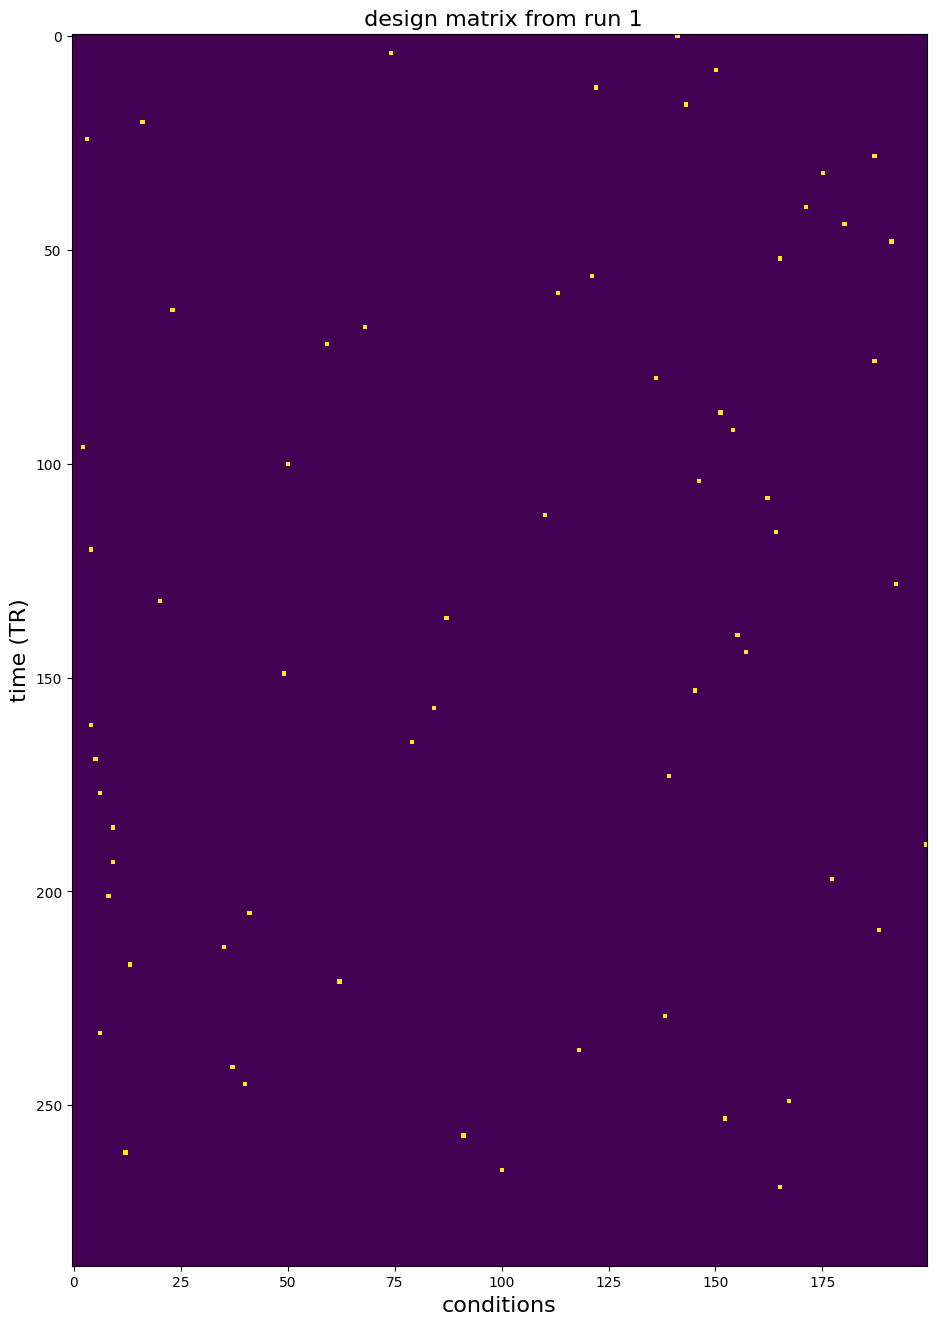

In [16]:
# Plot design matrix for a run
run=0
plt.figure(figsize=(16,16))
plt.imshow(design[run],interpolation='none')
plt.title(' design matrix from run %i' %(run+1), fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16)

In [17]:
# # find conditions that are repeated in the same run
# for i in range(16):
#     print(np.where(np.sum(design[i], axis=0) > 1))

In [18]:
# # find conditions that are repeated across all runs
# np.where((np.sum(np.sum(np.array(design), axis=1), axis=0) > 1))

## Create a brain mask that intersects each run's brain mask from fMRIPrep

From GLMSingle FAQ: The safest approach is to completely zero out the data for a voxel that does not have full data for all of the runs that you are analyzing with GLMsingle.

Loading average brain mask: /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/masks/sub-006/sub-006_ses-01_task-E_brain.nii.gz

Mask dimensions: (1.5, 1.5, 1.5)

Affine:
[[  1.5          0.           0.         -67.47249603]
 [  0.           1.5          0.         -73.40319824]
 [  0.           0.           1.5        -78.16244507]
 [  0.           0.           0.           1.        ]]

There are 412522.0 voxels in the included brain mask

Mask dimensions: (1.5, 1.5, 1.5)

Affine:
[[  1.5          0.           0.         -67.47249603]
 [  0.           1.5          0.         -73.40319824]
 [  0.           0.           1.5        -78.16244507]
 [  0.           0.           0.           1.        ]]

There are 412522.0 voxels in the included brain mask

all defaced T1 images have the same dimensions and affine!
Mask dimensions: (1.5, 1.5, 1.5)

Affine:
[[  1.5          0.           0.         -67.47249603]
 [  0.           1.5          0.         -73.40319824]
 [  0.      

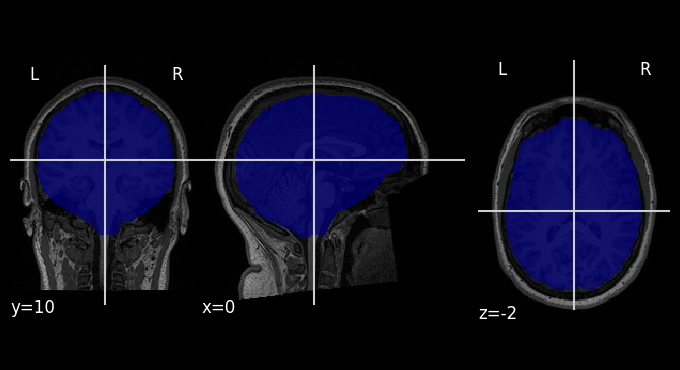

In [19]:
if make_avg_mask == 1:
    mask_imgs = []
    for ses in ses_list:
        func_dir = join(datadir,f'{ses}','func')
        print(func_dir)
        for run in range(1, runs_per_session.get(f'{ses}', 0) + 1):
            mask_name = f"{func_dir}/{sub}_{ses}_task-{func_task_name}_run-{run:02}_space-T1w_desc-brain_mask.nii.gz"
            mask_imgs.append(mask_name)

    func_masks = [nilearn.image.load_img(mask) for mask in mask_imgs]
    avg_mask = intersect_masks(func_masks, threshold=0.5, connected=True)

    # mask_imgs=[]
    # for run in range(1,n_runs+1):
    #     mask_name = f"{func_dir}/{sub}_{session}_task-{func_task_name}_run-{run:02}_space-T1w_desc-brain_mask.nii.gz"
    #     mask_imgs.append(mask_name)
    
    # avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)

    # Save the mask
    dimsize=avg_mask.header.get_zooms()
    affine_mat = avg_mask.affine
    hdr = avg_mask.header  # get a handle for the .nii file's header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
    output_name = f"{maskdir}/{sub}_{session_label}_{task}brain.nii.gz"
    print('Save average mask:', output_name)
    nib.save(avg_mask, output_name)
    print('')
    
elif make_avg_mask == 0:
    #Load brain mask
    file_in = maskdir + '/%s_%s_%sbrain.nii.gz' % (sub, session, task)
    print('Loading average brain mask:', file_in)
    print('')
    avg_mask=nib.load(file_in)

if ref_session not in ("", None):
    t1_file = f"{defaced_dir}{sub}_{ref_session}_T1w_defaced.nii.gz"
else:
    # verify all defaced T1 images have the same dimensions and affine
    t1_file = f"{defaced_dir}{sub}_{ses_list[0]}_T1w_defaced.nii.gz"
    t1_img = image.load_img(t1_file)
    dimsize, affine_mat, brain, xyz = utils.mask_info(avg_mask, t1_img)
    for ses in ses_list:
        t1_file = f"{defaced_dir}{sub}_{ses}_T1w_defaced.nii.gz"
        t1_img = image.load_img(t1_file)
        dimsize_ref, affine_mat_ref, brain_ref, xyz_ref = utils.mask_info(avg_mask, t1_img)
        assert np.all(dimsize == dimsize_ref) and np.all(affine_mat == affine_mat_ref) and np.all(brain == brain_ref) and np.all(xyz == xyz_ref)
    print("all defaced T1 images have the same dimensions and affine!")

t1_img = image.load_img(t1_file)

dimsize, affine_mat, brain, xyz = utils.mask_info(avg_mask, t1_img, plot=True)

if resample_voxel_size:
    assert dimsize[0] == dimsize[1] and dimsize[1] == dimsize[2], "voxels are not isometric"
    assert dimsize[2] != resampled_vox_size, f"attempting to resample from {dimsize[2]}mm to {resampled_vox_size}mm voxels"

## Apply mask to each run of functional data
Data will go from 4D (x,y,z,t) to 2D

In [20]:
for ses in ses_list:
    epi_file=f"{datadir}/{ses}/func/{sub}_{ses}_task-{func_task_name}_run-01_space-T1w_desc-preproc_bold.nii.gz"
    utils.compare_mask_epi_dims(epi_file, avg_mask)

checking epi data for run 1: /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/fmriprep/sub-006/ses-01/func/sub-006_ses-01_task-E_run-01_space-T1w_desc-preproc_bold.nii.gz

Dimensions: (1.5, 1.5, 1.5, 1.5)
Affine:
[[  1.5          0.           0.         -67.47249603]
 [  0.           1.5          0.         -73.40319824]
 [  0.           0.           1.5        -78.16244507]
 [  0.           0.           0.           1.        ]]

(92, 118, 95)
(92, 118, 95, 192)


In [21]:
# variables that will contain bold time-series and design matrices from each run
data = []
TR_run = []

for ses in ses_list:
    for run in range(runs_per_session.get(ses, 0)):
        filename = f"{outputdir}/{sub}/{sub}_{ses}_task-{func_task_name}_run-{(run+1):02}_2D_bold.npy"

        if load_epi == 1:
            epi_file = f"{datadir}/{ses}/func/{sub}_{ses}_task-{func_task_name}_run-{(run+1):02}_space-T1w_desc-preproc_bold.nii.gz"
            epi_mask_data = utils.fit_save_bold(epi_file, avg_mask, filename, run)
        elif load_epi == 0:
            print(f'\n*** Loading data from {filename} ***\n')
            epi_mask_data = np.load(filename)

        # Add this run's data to data variable
        data.append(epi_mask_data)
        TR_run.append(epi_mask_data.shape[1])

        print('BOLD data shape:', epi_mask_data.shape)
        print('TRs in this run:', epi_mask_data.shape[1])


print('')
print('number of runs in BOLD data:', len(data))  


*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-01_2D_bold.npy ***

BOLD data shape: (412522, 192)
TRs in this run: 192

*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-02_2D_bold.npy ***

BOLD data shape: (412522, 192)
TRs in this run: 192

*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-03_2D_bold.npy ***

BOLD data shape: (412522, 192)
TRs in this run: 192

*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-04_2D_bold.npy ***

BOLD data shape: (412522, 192)
TRs in this run: 192

*** Loading data from /jukebox/

## Resample voxel size 
We will optionally resample the voxel size of the functional runs

In [22]:
if resample_voxel_size:
    # set variables that are needed regardless of whether we want to run the voxel resampling (run_resample_voxel) or load in resampled data

    # mask paths
    m = '%s_%s_%sbrain' % (sub, session, task)
    mask_in_name = f"{maskdir}/{m}.nii.gz"
    mask_out_name = f"{resampled_dir}/{m}_{resampled_suffix}.nii.gz"

In [23]:
if resample_voxel_size:  
    # even if not performing resampling here (run_resample_voxel == False), do verification since this flag is True
    # check affines of all the bold runs we just loaded in 
    
    d0_affine = nilearn.masking.unmask(data[0].T, avg_mask).affine
    print(d0_affine)
    for d in range(len(data)):
        assert np.all(nilearn.masking.unmask(data[d].T, avg_mask).affine == d0_affine)
        boldref_filename = os.path.join(datadir, session, f'func/{sub}_{session}_task-{func_task_name}_run-{d+1:02}_space-T1w_boldref.nii.gz')
        assert np.all(nib.load(boldref_filename).affine == d0_affine)
        
    print("all the BOLD runs and boldref affines match!")

[[  1.5          0.           0.         -67.47249603]
 [  0.           1.5          0.         -73.40319824]
 [  0.           0.           1.5        -78.16244507]
 [  0.           0.           0.           1.        ]]
all the BOLD runs and boldref affines match!


In [24]:
if resample_voxel_size:
    # now that we've checked that the bold and boldrefs have the same affines (i.e. they're in the same space),
    # we just need to pick one of them and resample it to our desired voxel size using flirt, then use that as a 
    # reference image to resample all the bold runs. then proceed to the rest of the script as normal
    
    omat_name = f"{resampled_dir}/boldref_omat"
    ref_name = f"{resampled_dir}/boldref_resampled"
    print(f"path to save transformation matrix (should be the identity matrix): {omat_name}")
    print(f"path to save resampled boldref image: {ref_name}")

    utils.resample(boldref_filename, boldref_filename, resampled_vox_size, omat_name, output=ref_name)

    # assert that the resampled output matrix is the identity matrix; this should be true because we are not aligning to a different space, i.e. applying an affine/nonlinear transform, just changing the voxel size
    assert np.all(np.loadtxt(omat_name) == np.eye(4))
    assert exists(f"{ref_name}.nii.gz")

    if run_resample_voxel:
        all_out_names = []
        print("applying resampling to bold runs!")
        for d in tqdm(range(len(data))):
            resample_func_name = f"func/{sub}_{session}_task-{func_task_name}_run-{d+1:02}_space-T1w_desc-preproc_bold"
            in_name = os.path.join(datadir, session, f"{resample_func_name}.nii.gz")
            out_name = f"{resampled_dir}/{resample_func_name}_{resampled_suffix}.nii.gz"  # save to the resampled directory and add suffix. don't want to save to fmriprep directory, keep that clean
            utils.applyxfm(in_name, ref_name, omat_name, resample_method, output=out_name)
            all_out_names.append(out_name)

path to save transformation matrix (should be the identity matrix): /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/boldref_omat
path to save resampled boldref image: /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/boldref_resampled

*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/fmriprep/sub-006/ses-01/func/sub-006_ses-01_task-E_run-05_space-T1w_boldref.nii.gz ***


*** Saved resampled data to /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/boldref_resampled ***



In [25]:
if resample_voxel_size and run_resample_voxel:
    # resample the avg_mask
    utils.applyxfm(mask_in_name, ref_name, omat_name, resample_method, output=mask_out_name)
    utils.apply_thresh(mask_out_name, 0.5, output=mask_out_name)  # binarize the mask since resampling can result in non- 0 or 1 values

    # # print information and compare mask to functional data
    resampled_mask = nib.load(mask_out_name)
    assert set(np.unique(resampled_mask.get_fdata())) <= {0,1}  # make sure mask is boolean
    
    utils.compare_mask_epi_dims(out_name, resampled_mask)

    # now that we've confirmed that the mask and functional data share affines and dimensions, apply new mask to the resampled functional data
    print("applying resampled mask to resampled functional data")
    for d in tqdm(range(len(data))):
        resample_func_name = f"func/{sub}_{session}_task-{func_task_name}_run-{d+1:02}_space-T1w_desc-preproc_bold"
        out_npy_name = f"{resampled_dir}/{resample_func_name}_{resampled_suffix}.npy"
        print(out_npy_name)
        data[d] = utils.fit_save_bold(all_out_names[d], resampled_mask, out_npy_name, d)
    
    avg_mask = resampled_mask  # replace the old avg_mask with the resampled mask from here on

In [26]:
if resample_voxel_size and not run_resample_voxel:
    for d in range(len(data)):
        resample_func_name = f"func/{sub}_{session}_task-{func_task_name}_run-{d+1:02}_space-T1w_desc-preproc_bold"
        out_npy_name = f"{resampled_dir}/{resample_func_name}_{resampled_suffix}.npy"
        assert exists(out_npy_name)  # if we want to resample voxel size but not recompute it, the file must exist
        print(f"loading data from: {out_npy_name}")
        data[d] = np.load(out_npy_name)

    print("\nresampled data loaded!")
    print(f"data shape: {data[0].shape}")

loading data from: /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/func/sub-006_ses-01_task-E_run-01_space-T1w_desc-preproc_bold_resampled_2_5mm_trilinear.npy
loading data from: /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/func/sub-006_ses-01_task-E_run-02_space-T1w_desc-preproc_bold_resampled_2_5mm_trilinear.npy
loading data from: /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/func/sub-006_ses-01_task-E_run-03_space-T1w_desc-preproc_bold_resampled_2_5mm_trilinear.npy
loading data from: /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/func/sub-006_ses-01_task-E_run-04_space-T1w_desc-preproc_bold_resampled_2_5mm_trilinear.npy
loading data from: /jukebox/norman/rsiyer/rt

Mask dimensions: (2.5, 2.5, 2.5)

Affine:
[[  2.5          0.           0.         -65.97249603]
 [  0.           2.5          0.         -73.40319824]
 [  0.           0.           2.5        -78.16244507]
 [  0.           0.           0.           1.        ]]

There are 88972.0 voxels in the included brain mask

shape: (55, 70, 57)


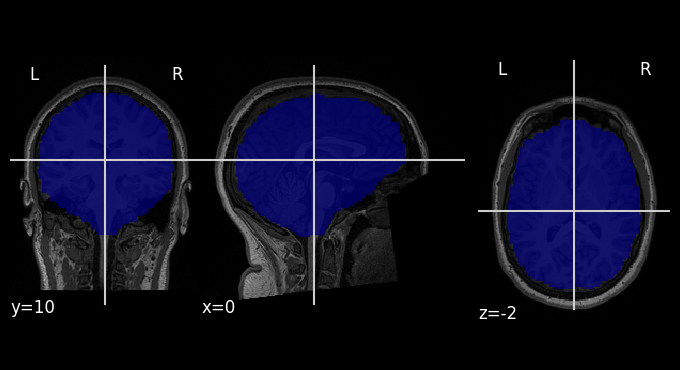

In [27]:
if resample_voxel_size and not run_resample_voxel:
    avg_mask = nib.load(mask_out_name)  # load the resampled mask from path to override avg_mask
    dimsize, affine_mat, brain, xyz = utils.mask_info(avg_mask, t1_img, plot=True)
    print("shape:", brain.shape)

## Upsample fMRI data to 1-sec TR
At this point, we have extracted all brain voxels and flattened the data to 2D (voxels,TR). 
Now we will interpolate the time-series to go from 1.5 sec TR to 1 sec TR. 

In [28]:
# import importlib
# importlib.reload(sys.modules['tseriesinterp'])
# from tseriesinterp import tseriesinterp

In [29]:
# voxel_id=500

# f, ax = plt.subplots(1,1, figsize=(14,5))
# ax.plot(data[0][voxel_id, :])
# ax.set_title('Voxel time series before upsampling, voxel id = %d' % voxel_id)
# ax.set_xlabel('TR')
# ax.set_ylabel('Voxel Intensity')

# f, ax = plt.subplots(1,1, figsize=(14,5))
# ax.plot(data_upsampled[voxel_id, :])
# ax.set_title('Voxel time series after upsampling, voxel id = %d' % voxel_id)
# ax.set_xlabel('TR')
# ax.set_ylabel('Voxel Intensity')


In [30]:
data_upsampled = []
TR_run_upsampled = []

# if run_upsampling == 1:
#     for ses in ses_list:
#         for run in range(runs_per_session.get(ses, 0)):
#             filename = f"{outputdir}/{sub}/{sub}_{ses}_task-{func_task_name}_run-{(run+1):02}_2D_upsampled_bold"
#             print(f'\n*** Saving data to {filename} ***\n')

#             # perform interpolation
#             data_new = tseriesinterp(data[run], tr_orig, tr, dim=1)
        
#             # add this run's data to data variable
#             data_upsampled.append(data_new)
#             TR_run_upsampled.append(data_new.shape[1])
                
#             print('BOLD data shape:', data_upsampled[run].shape)
#             print('TRs in this run:', TR_run_upsampled[run])
        
#             # save individual run data to npy file
#             np.save(filename, data_new)

# elif run_upsampling == 0:
#     for ses in ses_list:
#         for run in range(runs_per_session.get(ses, 0)):
#             filename = f"{outputdir}/{sub}/{sub}_{ses}_task-{func_task_name}_run-{(run+1):02}_2D_upsampled_bold"
#             print(f'\n*** Loading data from {filename} ***\n')
#             data_new = np.load(filename)
            
#             data_upsampled.append(data_new)
#             TR_run_upsampled.append(data_new.shape[1])
            
#             print('BOLD data shape:', data_upsampled[run].shape)
#             print('TRs in this run:', TR_run_upsampled[run])

for ses in ses_list:
    for run in range(runs_per_session.get(ses, 0)):
        filename = f"{outputdir}/{sub}/{sub}_{ses}_task-{func_task_name}_run-{(run+1):02}_2D_upsampled_bold.npy"
        
        if run_upsampling == 1:
            print(f'\n*** Saving data to {filename} ***\n')
            # Perform interpolation
            data_new = tseriesinterp(data[run], tr_orig, tr, dim=1)
            # Save individual run data to npy file
            np.save(filename, data_new)
        else:
            print(f'\n*** Loading data from {filename} ***\n')
            data_new = np.load(filename)

        # Add this run's data to data_upsampled
        data_upsampled.append(data_new)
        TR_run_upsampled.append(data_new.shape[1])

        print('BOLD data shape:', data_new.shape)
        print('TRs in this run:', data_new.shape[1])

if len(data_upsampled) >= 1:
    for d in range(len(data_upsampled)-1):
        assert not np.all(data_upsampled[d] == data_upsampled[d+1])
print('')
print('number of runs in upsampled BOLD data:', len(data_upsampled))   


*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-01_2D_upsampled_bold.npy ***

BOLD data shape: (88972, 288)
TRs in this run: 288

*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-02_2D_upsampled_bold.npy ***

BOLD data shape: (88972, 288)
TRs in this run: 288

*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-03_2D_upsampled_bold.npy ***

BOLD data shape: (88972, 288)
TRs in this run: 288

*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/sub-006_ses-01_task-E_run-04_2D_upsampled_bold.npy ***

BOLD data shape: (88972, 288)
TRs in this run: 

In [31]:
# print some relevant metadata
print(f'There are {len(data_upsampled)} runs in total\n')
#print(f'N = {data[0].shape[1]} TRs per run\n')
print(f'XYZ dimensionality is: {xyz}\n')
print(f'The dimensions of the 2D data for each run are:')
for i in range(len(data_upsampled)):
    print(f'{data_upsampled[i].shape}') 
print(f'The stimulus duration is {stimdur} seconds\n')
print(f'The TR is {tr} seconds\n')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')  
# print(f'There are {np.sum(roi)} voxels in the included visual ROI\n')
print(f'Numeric precision of data is: {type(data[0][0,0])}\n')

There are 5 runs in total

XYZ dimensionality is: (55, 70, 57)

The dimensions of the 2D data for each run are:
(88972, 288)
(88972, 288)
(88972, 288)
(88972, 288)
(88972, 288)
The stimulus duration is 3 seconds

The TR is 1 seconds

There are 88972.0 voxels in the included brain mask

Numeric precision of data is: <class 'numpy.float32'>



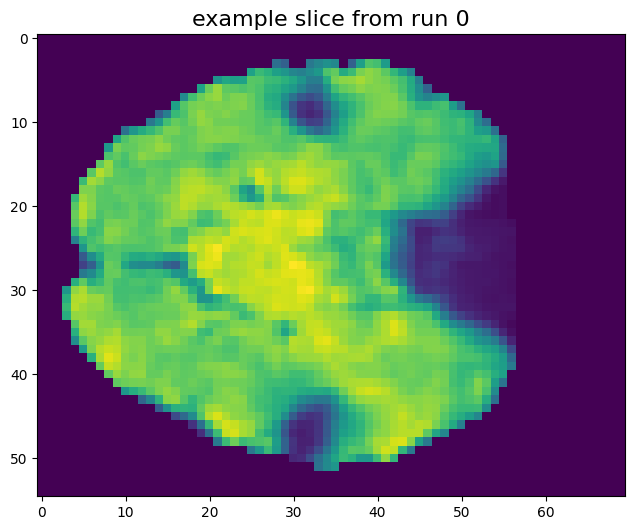

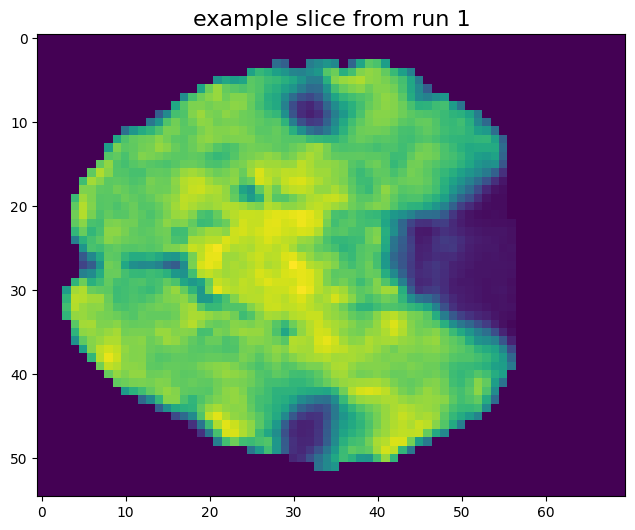

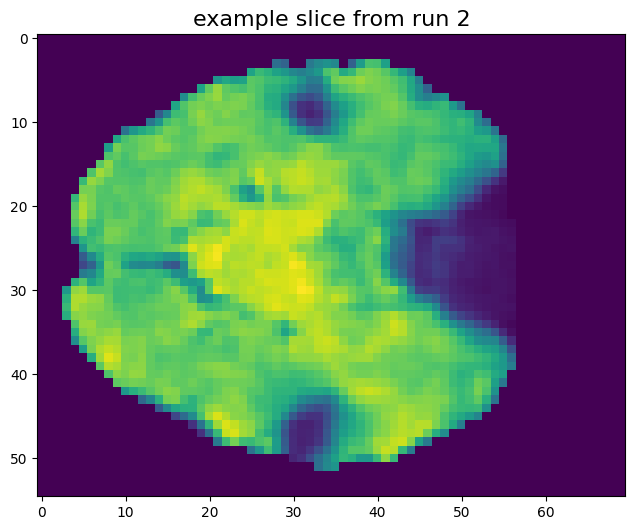

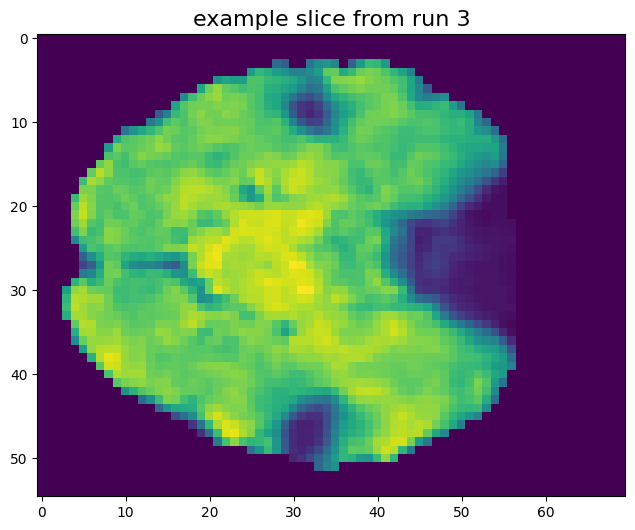

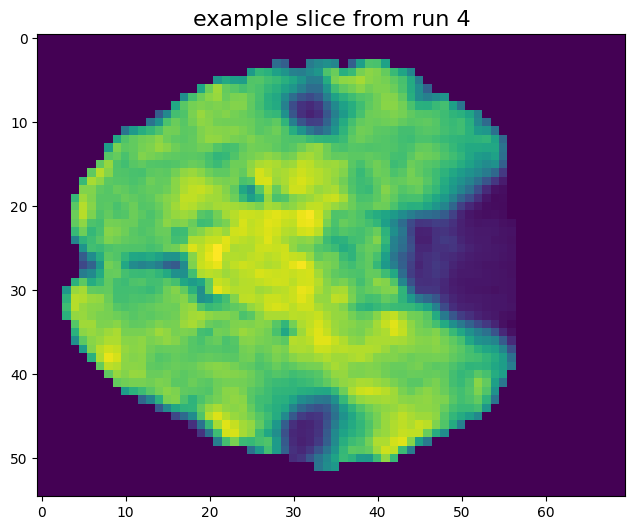

In [32]:
# plot example slice from run 1 and run 16
# first, we need to unmask the data to get it back into 3D/4D format:
z=round(xyz[2]/3)
for runnum in range(n_runs):
    X = nilearn.masking.unmask(data_upsampled[runnum].T, avg_mask)
    run = X.get_fdata()

    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.title(f'example slice from run {runnum}',fontsize=16)
    plt.imshow(run[:,:,z,0])

Text(0.5, 1.0, 'example slice from last run')

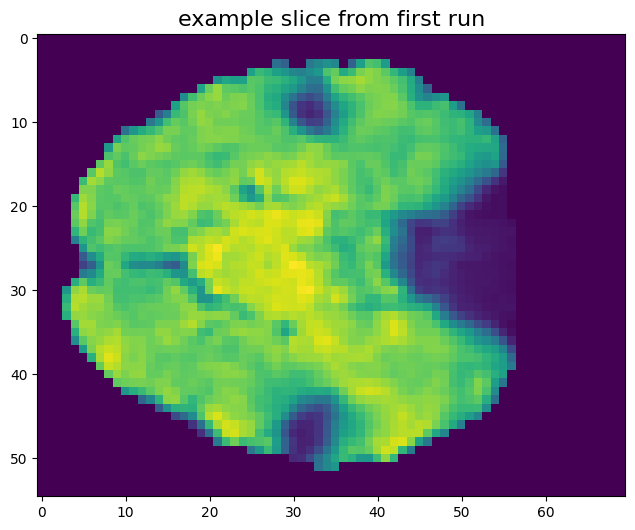

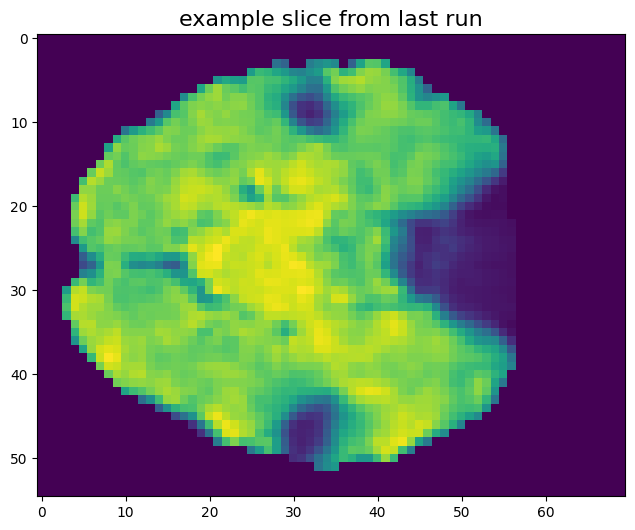

In [33]:
# plot example slice from run 1 and run 16
# first, we need to unmask the data to get it back into 3D/4D format:
X = nilearn.masking.unmask(data_upsampled[0].T, avg_mask)
run1 = X.get_fdata()

X = nilearn.masking.unmask(data_upsampled[n_runs-1].T, avg_mask)
run16 = X.get_fdata()

z=round(xyz[2]/3)
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(run1[:,:,z,0])
plt.title('example slice from first run',fontsize=16)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(run16[:,:,z,8])
plt.title('example slice from last run',fontsize=16)

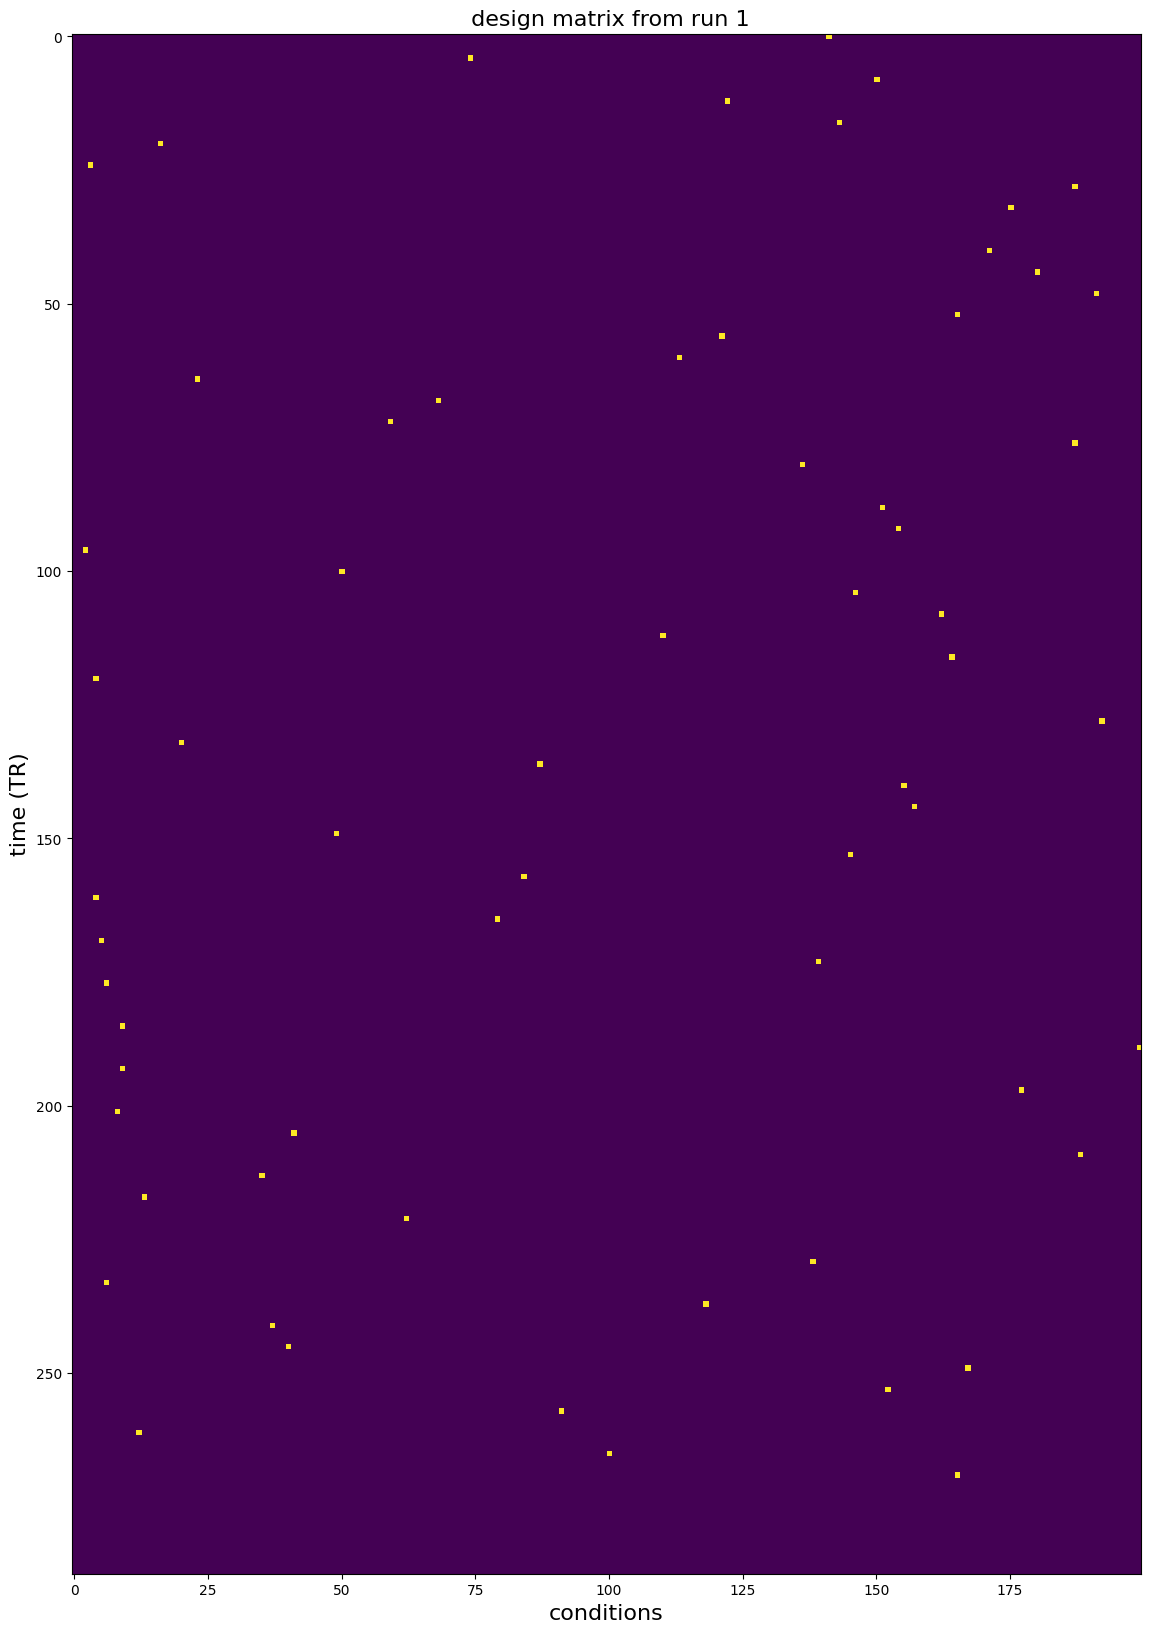

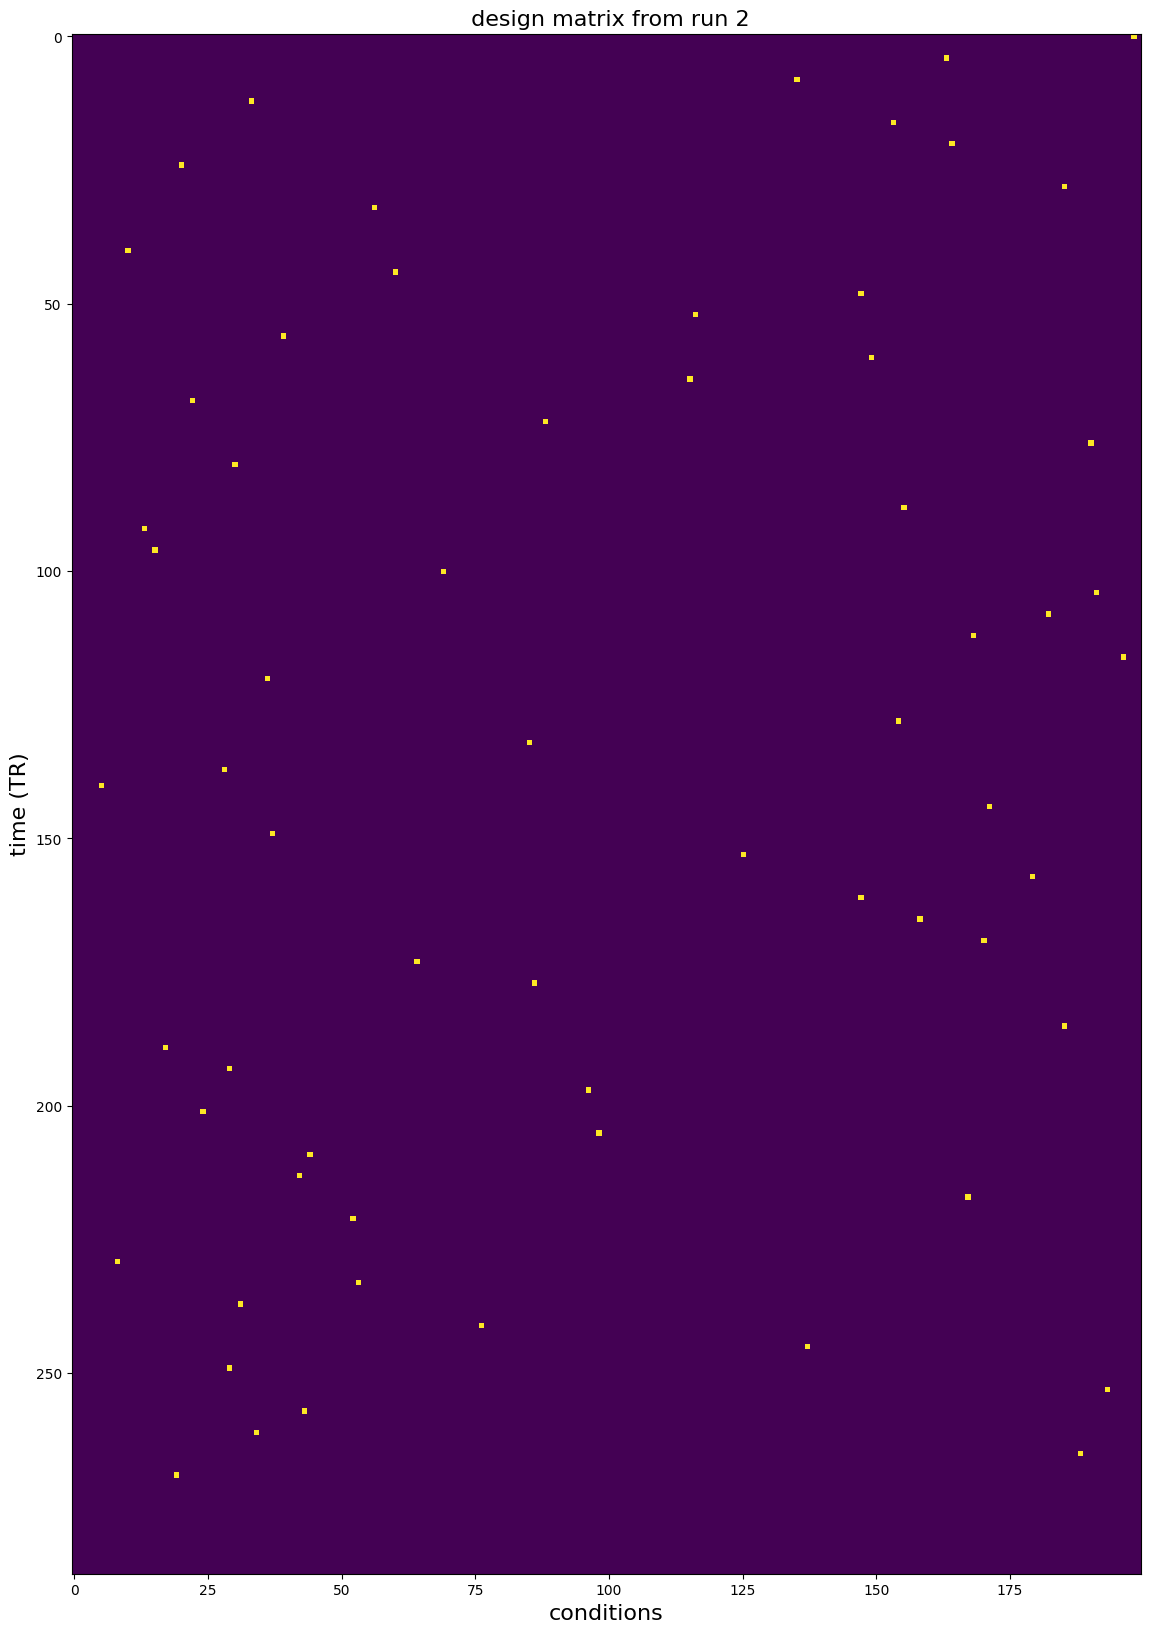

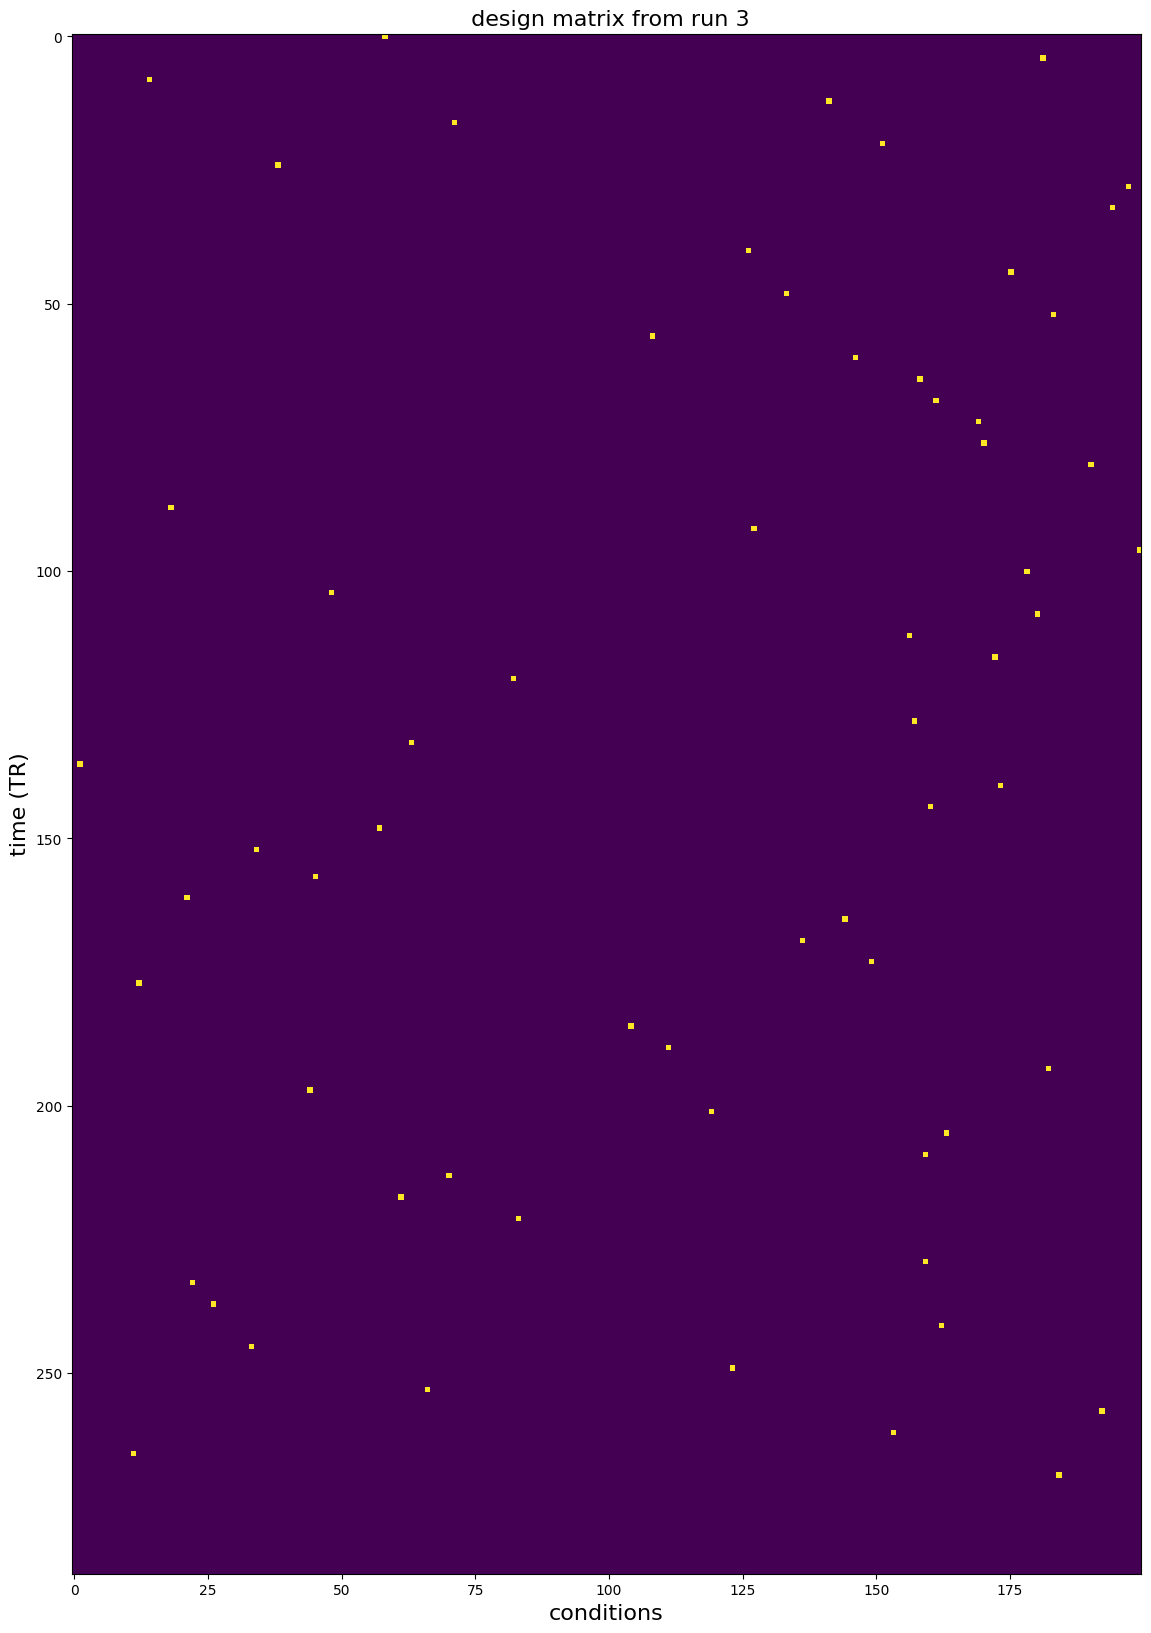

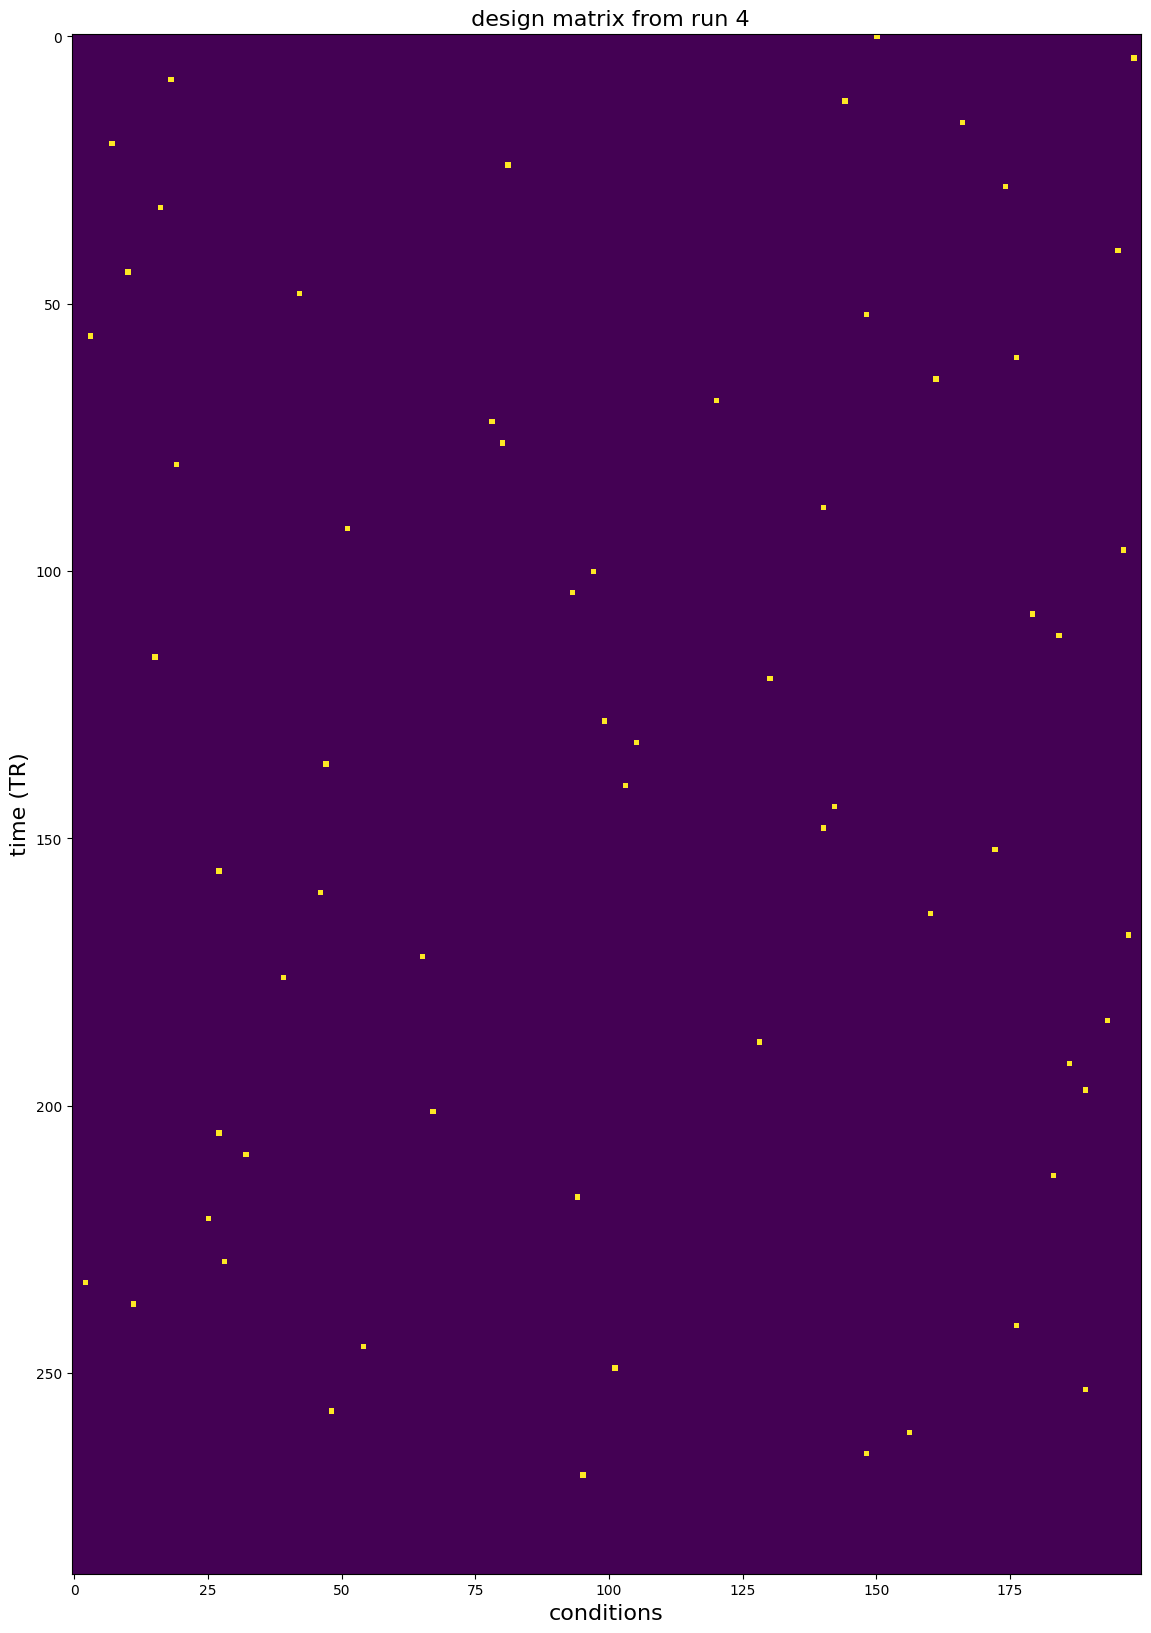

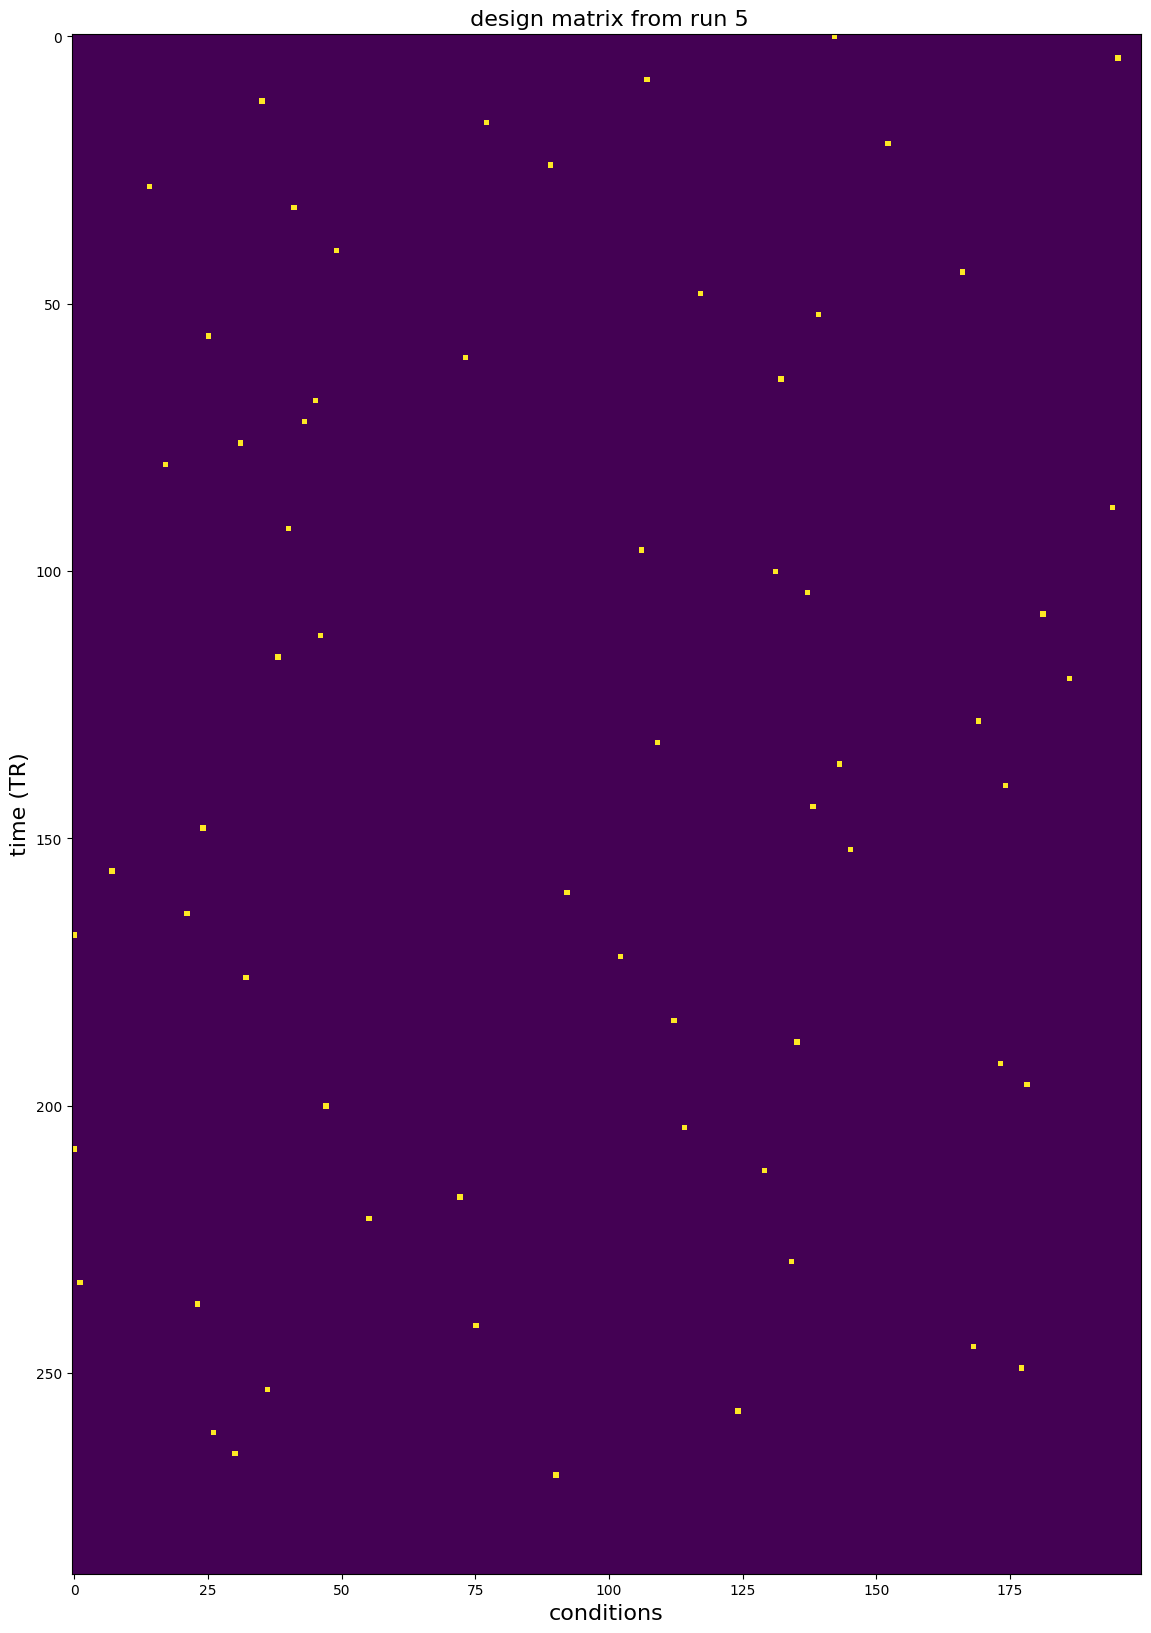

In [34]:
# Plot design matrix for each run
for run in range(n_runs):
    plt.figure(figsize=(20,20))
    plt.imshow(design[run][:,:],interpolation='none')
    plt.title(' design matrix from run %i' %(run+1), fontsize=16)
    plt.xlabel('conditions',fontsize=16)
    plt.ylabel('time (TR)',fontsize=16) 

## Run GLMsingle with default parameters to estimate single-trial betas

In [35]:
# outputs and figures will be stored in a folder (you can specify its name
# as the 5th output to GLMsingle). model estimates can be also
# saved to the 'results' variable which is the only output of
# GLMsingle.

# optional parameters below can be assigned to a structure, i.e., opt =
# dict('wantlibrary':1, 'wantglmdenoise':1); options are the 6th input to
# GLMsingle.

# there are many options that can be specified; here, we comment on the
# main options that one might want to modify/set. defaults for the options
# are indicated below.

# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
# chunklen = 50000 -> is the number of voxels that we will
#    process at the same time. for setups with lower memory, you may need to 
#    decrease this number.

# wantmemoryoutputs is a logical vector [A B C D] indicating which of the
#     four model types to return in the output <results>. the user must be
#     careful with this, as large datasets can require a lot of RAM. if you
#     do not request the various model types, they will be cleared from
#     memory (but still potentially saved to disk). default: [0 0 0 1]
#     which means return only the final type-D model.

# wantfileoutputs is a logical vector [A B C D] indicating which of the
#     four model types to save to disk (assuming that they are computed). A
#     = 0/1 for saving the results of the ONOFF model, B = 0/1 for saving
#     the results of the FITHRF model, C = 0/1 for saving the results of the
#     FITHRF_GLMdenoise model, D = 0/1 for saving the results of the
#     FITHRF_GLMdenoise_RR model. default: [1 1 1 1] which means save all
#     computed results to disk.

# numpcstotry (optional) is a non-negative integer indicating the maximum
#     number of GLMdenoise PCs to enter into the model. default: 10.

# fracs (optional) is a vector of fractions that are greater than 0
#     and less than or equal to 1. we automatically sort in descending
#     order and ensure the fractions are unique. these fractions indicate
#     the regularization levels to evaluate using fractional ridge
#     regression (fracridge) and cross-validation. default:
#     fliplr(.05:.05:1). a special case is when <fracs> is specified as a
#     single scalar value. in this case, cross-validation is NOT performed
#     for the type-D model, and we instead blindly use the supplied
#     fractional value for the type-D model.

In [36]:
# create a directory for saving GLMsingle outputs
# outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')
outputdir_glmsingle = join(outputdir, sub, f'glmsingle_{session_label}')
figuredir_glmsingle = join(outputdir, 'figures', sub)
os.makedirs(outputdir_glmsingle,exist_ok=True)
os.makedirs(figuredir_glmsingle,exist_ok=True)

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [0,0,0,1]
opt['wantmemoryoutputs'] = [1,1,1,1]
#opt['wanthdf5'] = 1

if session == "all":
    opt['sessionindicator'] = np.concatenate([
        np.full(runs, i + 1)  # 1-based indexing
        for i, runs in enumerate(runs_per_session.values())
        ])
    print("***Using sessionindicator because this is a multi-session scan***", opt['sessionindicator'])

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1752092737.4271514,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [0, 0, 0, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [37]:
print('shape of data before running GLMsingle:')
print(data_upsampled[0].shape)
print('shape of design matrix:')
print(design[0].shape)

shape of data before running GLMsingle:
(88972, 288)
shape of design matrix:
(288, 200)


In [38]:
# Try running with brainexclude=avg_mask
# if it crashes, then increase max to 1,500,000

# this example saves output files to the outputdir folder
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

#if not exists(outputdir_glmsingle):
if run_glmsingle == 1:
    print('saving outputs to', outputdir_glmsingle)
    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data_upsampled,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle,
       figuredir=figuredir_glmsingle
       )
    
    # save results in memory to npz
    np.savez(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'), **results_glmsingle['typea'])
    np.savez(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'), **results_glmsingle['typeb'])
    np.savez(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'), **results_glmsingle['typec'])
    np.savez(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'), **results_glmsingle['typed'])
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
elif run_glmsingle == 0:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    # takes about 2 minutes to load
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    
    if opt['wanthdf5'] == 1: #if outputs are in hdf5 format
        results_intm = dict()
        results_intm['typea'] = h5py.File(join(outputdir_glmsingle,'TYPEA_ONOFF.hdf5'), 'r')
        results_intm['typeb'] = h5py.File(join(outputdir_glmsingle,'TYPEB_FITHRF.hdf5'), 'r')
        results_intm['typec'] = h5py.File(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.hdf5'), 'r')
        results_intm['typed'] = h5py.File(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.hdf5'), 'r')
        
        model_types = ['typea', 'typeb', 'typec', 'typed']
        for model in range(len(model_types)):
            results_glmsingle[model_types[model]] = dict()
            plot_fields = list(results_intm[model_types[model]].keys())
    
            for i in range(len(plot_fields)):
                results_glmsingle[model_types[model]][plot_fields[i]] = results_intm[model_types[model]].get(plot_fields[i]).value
    
    else: #load npy files
        #results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
        #results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
        #results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
        #results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

        # outputdir_glmsingle = '/jukebox/norman/rsiyer/rtmindeye/data/bids/derivatives/glmsingle/sub-003/glmsingle_ses-01'
        results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'))
        results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'))
        results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'))
        results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'))
        
elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

loading existing GLMsingle outputs from directory:
	/jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/glmsingle_ses-01
	elapsed time:  00:00:00


In [39]:
# results_glmsingle['typea']['onoffR2'].shape

In [40]:
# avg_mask.get_fdata().shape

## Summary of important outputs

the outputs of GLMsingle are formally documented in its header. here, we highlight a few of the more important outputs:

* R2 -> is model accuracy expressed in terms of R^2 (percentage).

* betasmd -> is the full set of single-trial beta weights (X x Y x Z x TRIALS). beta weights are arranged in chronological order.

* HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered with getcanonicalHRFlibrary(stimdur,tr)

* FRACvalue -> is the fractional ridge regression regularization level chosen for each voxel. values closer to 1 mean less regularization.

In [41]:
# GLMsingle output is in 2D format (voxels,samples)
# we need to unmask the data to get it back into 3D/4D format:
# X = nilearn.masking.unmask(results_glmsingle['typeb']['HRFindex'], avg_mask)
# X_hrf = X.get_fdata()

In [42]:
# results_out = {
#                     'onoffR2': np.reshape(onoffR2, [nx, ny, nz]),
#                     'meanvol': np.reshape(meanvol, [nx, ny, nz]),
#                     'betasmd': np.reshape(betasmd, [nx, ny, nz])
#                     }

In [43]:
# convert everything back to 3D/4D array format
model_types = ['typea','typeb','typec','typed']

results_glmsingle_3D = dict()

for model in range(len(model_types)):
    results_glmsingle_3D[model_types[model]] = dict()
    
    #plot_fields = list(results_glmsingle[model_types[model]].keys())
    #print(model, plot_fields)
    
    if model == 0: #type A
        plot_fields = ['betasmd','meanvol','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex', 'FitHRFR2']
    elif model == 2: #type C
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex']
    elif model == 3: #type D
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex','FRACvalue']
    print(model_types[model])
    
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        # find time dimension
        dim = len(results_glmsingle[model_types[model]][plot_fields[i]].shape)-1
        # flatten to 2D
        mflat = reshape2D(results_glmsingle[model_types[model]][plot_fields[i]],dim) 
        print('original shape:', results_glmsingle[model_types[model]][plot_fields[i]].shape)
        print('2D shape:', mflat.shape)
        # if sub == 'sub-001' and session == 'ses-01':
        #     unmask_data = nilearn.masking.unmask(results_glmsingle[model_types[model]][plot_fields[i]].T, avg_mask)
        # else:
        unmask_data = nilearn.masking.unmask(mflat, avg_mask)
        results_glmsingle_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_glmsingle_3D[model_types[model]][plot_fields[i]].shape)
        print('')

typea
betasmd
original shape: (88972, 1, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

meanvol
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

onoffR2
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

typeb
betasmd
original shape: (88972, 1, 1, 315)
2D shape: (315, 88972)
shape of unmasked data: (55, 70, 57, 315)

meanvol
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

R2
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

HRFindex
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

FitHRFR2
original shape: (88972, 1, 1, 20)
2D shape: (20, 88972)
shape of unmasked data: (55, 70, 57, 20)

typec
betasmd
original shape: (88972, 1, 1, 315)
2D shape: (315, 88972)
shape of unmasked data: (55, 70, 57, 315)

meanvol
original shape: (88972, 1, 1)
2D shape: (1, 88972)

## Plot a slice of brain showing GLMsingle outputs

In [44]:
# results_glmsingle_3D['typeb'][plot_fields[i]].shape

In [45]:
# # we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# # which contains the full set of GLMsingle optimizations.

# # choose a slice
# #z=round(xyz[2]/3)
# z=35

# # we will plot betas, R2, optimal HRF indices, and the voxel frac values
# plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
# #plot_fields = ['betasmd']
# colormaps = ['RdBu_r','hot','jet','copper']
# clims = [[-5,5],[0,85],[0,20],[0,1]]

# plt.figure(figsize=(12,8))

# for i in range(len(plot_fields)):
    
#     plt.subplot(2,2,i+1)
    
#     if i == 0:
#         # when plotting betas, for simplicity just average across all image presentations
#         # this will yield a summary of whether voxels tend to increase or decrease their 
#         # activity in response to the experimental stimuli (similar to outputs from 
#         # an ONOFF GLM)
#         plot_data = np.nanmean(np.squeeze(results_assumehrf_3D['typeb'][plot_fields[i]]),3)
#         titlestr = 'average GLM betas (1000 trials)'
    
#     else:
#         # plot all other voxel-wise metrics as outputted from GLMsingle
#         plot_data = np.squeeze(results_assumehrf_3D['typeb'][plot_fields[i]].reshape(xyz))
#         titlestr = plot_fields[i]
    
#     plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
#     plt.colorbar()
#     plt.title(titlestr)
#     plt.axis(False)

In [46]:
# # we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# # which contains the full set of GLMsingle optimizations.

# # choose a slice
# #z=round(xyz[2]/3)
# z=30

# # we will plot betas, R2, optimal HRF indices, and the voxel frac values
# plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
# #plot_fields = ['betasmd']
# colormaps = ['RdBu_r','hot','jet','copper']
# clims = [[-5,5],[0,85],[0,20],[0,1]]

# plt.figure(figsize=(12,8))



# if i == 0:
#     # when plotting betas, for simplicity just average across all image presentations
#     # this will yield a summary of whether voxels tend to increase or decrease their 
#     # activity in response to the experimental stimuli (similar to outputs from 
#     # an ONOFF GLM)
#     plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]]),3)
#     titlestr = 'average GLM betas (1000 trials)'
    
# plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
# plt.colorbar()
# plt.title(titlestr)
# plt.axis(False)

In [47]:
# np.all(np.squeeze(results_glmsingle_3D['typec']['betasmd']) == results_glmsingle_3D['typec']['betasmd'])

In [48]:
# results_assumehrf_3D['typeb']['betasmd'].shape

In [49]:
# plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typeb']['betasmd']),3)
# plt.imshow(plot_data[:, :, 40],clim=[-.4,.4])

In [50]:
# np.nanmean(np.squeeze(results_glmsingle_3D['typea']['betasmd']),3)

In [51]:
# # we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# # which contains the full set of GLMsingle optimizations.

# # choose a slice
# #z=round(xyz[2]/3)
# z=48

# # we will plot betas, R2, optimal HRF indices, and the voxel frac values
# plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
# #plot_fields = ['betasmd']
# colormaps = ['RdBu_r','hot','jet','copper']
# clims = [[-0.5,0.5],[0,20],[0,20],[0,1]]

# plt.figure(figsize=(12,8))

# for i in range(len(plot_fields)):
    
#     plt.subplot(2,2,i+1)
    
#     if i == 0:
#         # when plotting betas, for simplicity just average across all image presentations
#         # this will yield a summary of whether voxels tend to increase or decrease their 
#         # activity in response to the experimental stimuli (similar to outputs from 
#         # an ONOFF GLM)
#         plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]]),3)
#         titlestr = 'average GLM betas (1000 trials)'
    
#     else:
#         # plot all other voxel-wise metrics as outputted from GLMsingle
#         plot_data = np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]].reshape(xyz))
#         titlestr = plot_fields[i]
    
#     plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
#     plt.colorbar()
#     plt.title(titlestr)
#     plt.axis(False)

Mask dimensions: (2.5, 2.5, 2.5)

Affine:
[[  2.5          0.           0.         -65.97249603]
 [  0.           2.5          0.         -73.40319824]
 [  0.           0.           2.5        -78.16244507]
 [  0.           0.           0.           1.        ]]

There are 88972.0 voxels in the included brain mask



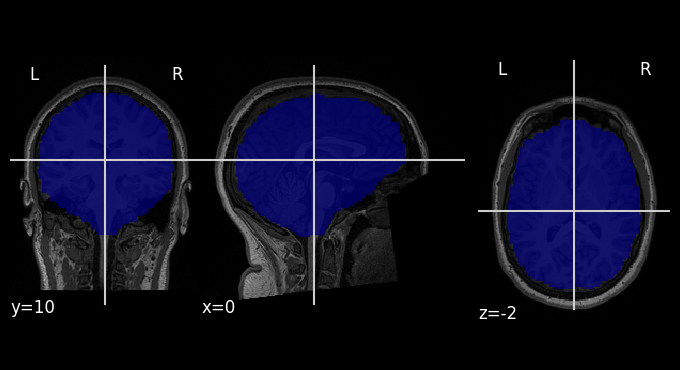

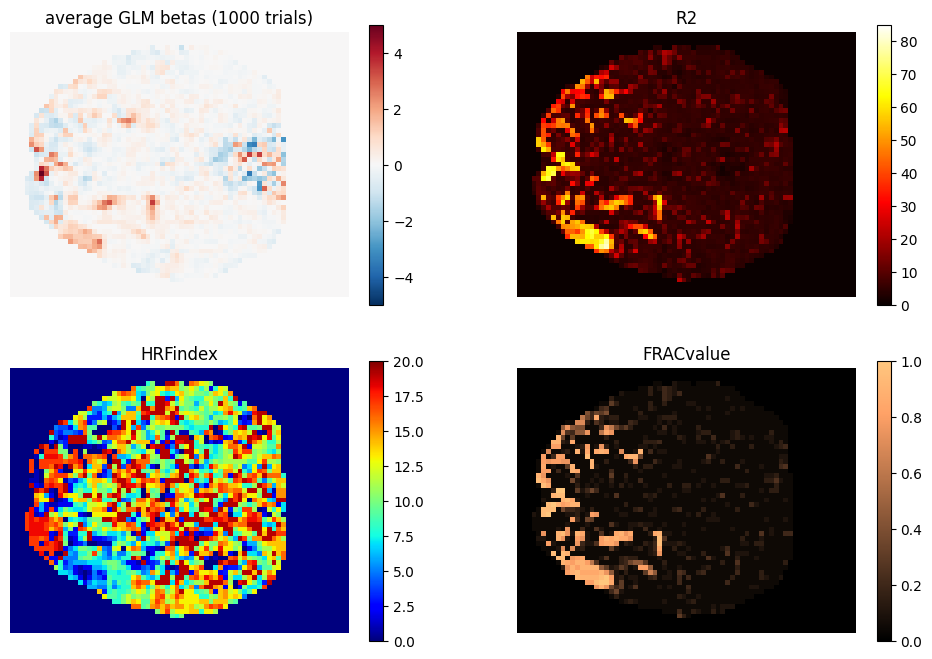

saved betas as nifti image!


In [52]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.
dimsize, affine_mat, brain, xyz = utils.mask_info(avg_mask, t1_img, plot=True)

# choose a slice
z=round(xyz[2]/3)
# z=38

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
#plot_fields = ['betasmd']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]]),3)
        titlestr = 'average GLM betas (1000 trials)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)
    nib.save(nib.Nifti1Image(plot_data, affine_mat), f"{outputdir_glmsingle}/beta_map_{plot_fields[i]}")

plt.savefig(f'{figuredir_glmsingle}/glmsingle_outputs_slice{z}')
plt.show()

print("saved betas as nifti image!")

## Run a baseline GLM to compare with GLMsingle outputs

In [53]:
# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise, or ridge regression regularization. we
# will compute the split-half reliability at each voxel using this baseline
# GLM, and then assess whether reliability improves using the output betas
# from GLMsingle. 

# output directory for baseline GLM
outputdir_baseline = join(outputdir, sub, 'glmbaseline')
os.makedirs(outputdir_baseline,exist_ok=True)

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed

opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]
#opt['wanthdf5'] = 1

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
pprint(glmbaseline_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1752092737.4271514,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wanthdf5': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [54]:
start_time = time.time()

# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.
#if not exists(outputdir_baseline):
if run_glmbaseline == 1:
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
       design,
       data_upsampled,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
    # save results in memory to npz
    np.savez(join(outputdir_baseline,'TYPEA_ONOFF.npz'), **results_assumehrf['typea'])
    np.savez(join(outputdir_baseline,'TYPEB_FITHRF.npz'), **results_assumehrf['typeb'])

elif run_glmbaseline == 0:
    
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_baseline}')
    
    results_assumehrf = dict()
    
    if opt['wanthdf5'] == 1: #if outputs are in hdf5 format
        results_intm2 = dict()
        results_intm2['typea'] = h5py.File(join(outputdir_baseline,'TYPEA_ONOFF.hdf5'), 'r')
        results_intm2['typeb'] = h5py.File(join(outputdir_baseline,'TYPEB_FITHRF.hdf5'), 'r')
        
        model_types = ['typea', 'typeb']
        for model in range(len(model_types)):
            results_assumehrf[model_types[model]] = dict()
            plot_fields = list(results_intm2[model_types[model]].keys())
    
            for i in range(len(plot_fields)):
                results_assumehrf[model_types[model]][plot_fields[i]] = results_intm2[model_types[model]].get(plot_fields[i]).value
    else:
        #results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
        #results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
        results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npz'))
        results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npz'))
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.
    
elapsed_time = time.time() - start_time
print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

loading existing GLMsingle outputs from directory:
	/jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/sub-006/glmbaseline
	elapsed time:  00:00:00


In [55]:
# convert back to 3D/4D array format
model_types = ['typea','typeb']

results_assumehrf_3D = dict()

for model in range(len(model_types)):
    results_assumehrf_3D[model_types[model]] = dict()
    if model == 0: #type A
        plot_fields = ['betasmd','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','R2','HRFindex']
    print(model_types[model])
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        # find time dimension
        dim = len(results_assumehrf[model_types[model]][plot_fields[i]].shape)-1
        # flatten to 2D
        mflat = reshape2D(results_assumehrf[model_types[model]][plot_fields[i]],dim) 
        print('original shape:', results_assumehrf[model_types[model]][plot_fields[i]].shape)
        print('2D shape:', mflat.shape)
        # if sub == 'sub-001' and session == 'ses-01':
        #     unmask_data = nilearn.masking.unmask(results_assumehrf[model_types[model]][plot_fields[i]].T, avg_mask)
        # else:
        unmask_data = nilearn.masking.unmask(mflat, avg_mask)
        results_assumehrf_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_assumehrf_3D[model_types[model]][plot_fields[i]].shape)
        print('')

typea
betasmd
original shape: (88972, 1, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

onoffR2
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

typeb
betasmd
original shape: (88972, 1, 1, 315)
2D shape: (315, 88972)
shape of unmasked data: (55, 70, 57, 315)

R2
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)

HRFindex
original shape: (88972, 1, 1)
2D shape: (1, 88972)
shape of unmasked data: (55, 70, 57, 1)



In [56]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf_3D['typeb']['betasmd']#.reshape(xyz + (1000,))
models['fithrf'] = results_glmsingle_3D['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle_3D['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle_3D['typed']['betasmd']

## Get indices of repeated conditions to use for reliability calculations

To compare the results of different GLMs we are going to calculate the voxel-wise split-half reliablity for each model. Reliability values reflect a correlation between beta weights for repeated presentations of the same conditions. In short, we are going to check how reliable/reproducible are the single trial responses to repeated conditions estimated with each GLM type.

In the code below, we are attempting to locate the indices in the beta weight GLMsingle outputs modelmd(x,y,z,trials) that correspond to repeated images.

In [57]:
if run_reliability == 1:
    
    # consolidate design matrices
    designALL = np.concatenate(design,axis=0)
    print('designALL shape (TRs, conditions):', designALL.shape)

    # construct a vector containing 0-indexed condition numbers in chronological order
    corder = []
    for p in range(designALL.shape[0]):
        if np.any(designALL[p]):
            corder.append(np.argwhere(designALL[p])[0,0])

    corder = np.array(corder)
    
    # let's take a look at the first few entries
    print(corder[:3])
    
    # note that [374 496 7] means that the first stimulus trial involved
    # presentation of the 374th condition (zero-indexed), the second stimulus trial 
    # involved presentation of the 496th condition, and so on.

designALL shape (TRs, conditions): (1440, 200)
[141  74 150]


In [58]:
# in order to compute split-half reliability, we have to do some indexing.
# we want to find images with least two repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

if run_reliability == 1:
    
    repindices = [] # 2 x images containing stimulus trial indices.

    # the first row refers to the first presentation; the second row refers to
    # the second presentation.
    for p in range(designALL.shape[1]): # loop over every condition

        temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
        #print(len(temp)) #vio condition should have 11 As, nonvio should have 9 As
        
        # only add repeated conditions to repindices
        if len(temp) >= 2:
            repindices.append([temp[0], temp[1]]) # note that for now we only look at first 2 repetitions

    repindices = np.vstack(np.array(repindices)).T
    print(repindices.shape, '(repetitions, condition)')

(2, 115) (repetitions, condition)


In [59]:
if run_reliability == 1:
    # let's take a look at a few entries
    print(repindices[:,:3])
    
    # notice that the first condition is presented on the 216th zero-indexed 
    # stimulus trial and the 485th stimulus trial, the second condition is presented on the
    # 217th and 620st stimulus trials, and so on.
    
    print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

# now, for each voxel we are going to correlate beta weights describing the
# response to images presented for the first time with beta weights
# describing the response from the repetition of the same image. with 136
# repeated conditions, the correlation for each voxel will reflect the

[[291 157  22]
 [300 305 242]]
there are 115 repeated conditions in the experiment


## Compute median split-half reliabilty within the ROI for each beta version

In [60]:
# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them
if run_reliability == 1:
    
    vox_reliabilities = [] # output variable for reliability values

    modelnames = list(models.keys())#[1:]
    print(modelnames)

    # for each beta version...
    for m in range(len(modelnames)):

        print(f'computing reliability for beta version: {modelnames[m]}')
        time.sleep(1)

        # get the repeated-condition GLM betas using our repindices variable
        betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
        # betas = models[modelnames[m]]['betasmd'][:,None,None,:][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
        x,y,z = betas.shape[:3] 

        rels = np.full((x,y,z),np.nan)

        # loop through voxels in the 3D volume...
        for xx in tqdm(range(x)):
            for yy in range(y):
                for zz in range(z):

                    # reliability at a given voxel is pearson correlation between response profiles from first and 
                    # second image presentations (dim = 136 conditions)
                    rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                                 betas[xx,yy,zz,1])[1,0]

        vox_reliabilities.append(rels)

['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
computing reliability for beta version: assumehrf


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


computing reliability for beta version: fithrf


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


computing reliability for beta version: fithrf_glmdenoise


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


computing reliability for beta version: fithrf_glmdenoise_rr


100%|██████████| 55/55 [00:15<00:00,  3.47it/s]


In [ ]:
# load mask defining liberal visual cortex ROI
mask = 'nsdgeneral'

nsd_masks = []
for ses in ses_list:
    mask_file = f"{maskdir}/{sub}_{ses}_task-{func_task_name}_{mask}.nii.gz"
    if resample_voxel_size:
        mask_file_resampled = resampled_dir + '/%s_%s_%s%s_%s.nii.gz' % (sub,session,task,mask, resampled_suffix)
        # if run_resample_voxel:
        utils.applyxfm(mask_file, ref_name, omat_name, resample_method, output=mask_file_resampled)
        os.system(f"fslmaths {mask_file_resampled} -thr 0.5 -bin {mask_file_resampled}")  # binarize the mask in-place
        mask_file = mask_file_resampled  # ensure you load the resampled file instead

    print(mask_file)
    nsd_masks.append(mask_file)

nsd_masks = [nilearn.image.load_img(mask) for mask in nsd_masks]
mask_data = intersect_masks(nsd_masks, threshold=0.5, connected=True)
# Apply brain mask to ensure voxels in mask_data are within brain
mask_data = nilearn.image.math_img('img1 * img2', img1=mask_data, img2=avg_mask)

    
# mask_data=nib.load(mask_file)
roi=mask_data.get_fdata()
print('roi shape:', roi.shape)
print(np.min(roi), np.max(roi))

roi = roi.astype(float)
# convert voxels outside ROI to nan for overlay plotting
roi[roi==0] = np.nan 
print(np.nanmin(roi), np.nanmax(roi))
print(roi.shape)

roi = roi.flatten()
brain_mask = avg_mask.get_fdata().flatten()
roi = roi[brain_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(roi.shape)


*** Loading data from /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/masks/sub-006/sub-006_ses-01_task-E_nsdgeneral.nii.gz ***


*** Saved resampled data to /jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/sub-006_ses-01_task-E_nsdgeneral_resampled_2_5mm_trilinear.nii.gz ***

/jukebox/norman/rsiyer/rtmindeye/data_sub-006/bids/derivatives/glmsingle_ses-01_task-E_resampled_2_5mm_trilinear/resampled_data/sub-006_ses-01_task-E_nsdgeneral_resampled_2_5mm_trilinear.nii.gz
roi shape: (55, 70, 57)
0.0 1.0
1.0 1.0
(55, 70, 57)
(88972,)


In [65]:
# Save voxel reliabilities in NSDgeneral ROI
if run_reliability == 1:
    vox_rel_nsdgeneral = []
    for vr in vox_reliabilities:
        vox_rel_nsdgeneral.append(vr[avg_mask.get_fdata()==1][roi==True])
        
    np.save(join(savedir,'voxel_reliabilities_NSDgeneral.npy'), vox_rel_nsdgeneral)

## Assess change in reliability yielded by GLMsingle

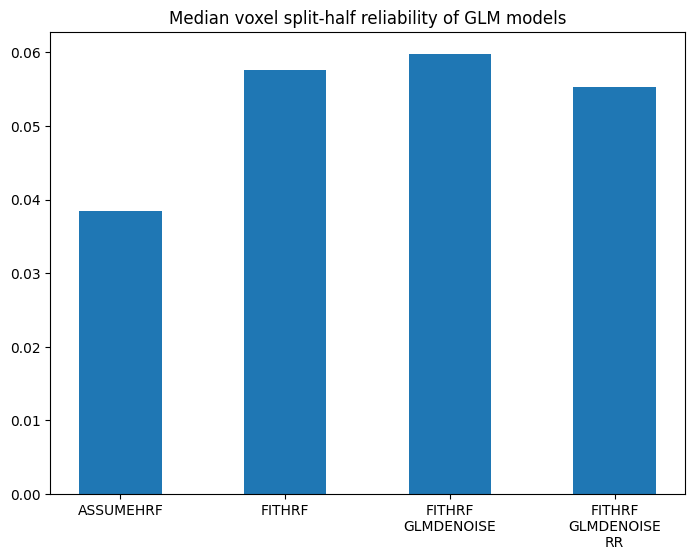

In [66]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph
if run_reliability == 1:
    comparison = []
    for vr in vox_reliabilities:
        # comparison.append(np.nanmedian(vr)) 
        comparison.append(np.nanmedian(vr[avg_mask.get_fdata()==1][roi==True]))

    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.bar(np.arange(len(comparison)),comparison,width=0.5)
    plt.title('Median voxel split-half reliability of GLM models')
    plt.xticks(np.arange(4),np.array(['ASSUMEHRF','FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']))
    #plt.ylim([0.1,0.2])
    plt.savefig(f'{figuredir_glmsingle}/split-half_reliability')
    plt.show()

In [67]:
datasets = ['v1'] #glmsingle versions

info = dict()
info['v1'] = dict()
info['v1']['subjs'] = ['sub-001']
info['methods'] = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']


In [68]:
reliability = dict()

#masks = np.load('masks.npy',allow_pickle=True).item() 

# check to be sure all the datafiles exist
for ds in datasets:
    
    reliability[ds] = dict()
    
    for subj in info[ds]['subjs']:
        
        subj_version_list = []
        
        reliability[ds][subj] = dict()

        # load this versions's data
        if ds == 'v1':    
            temp = np.load(join(savedir,'voxel_reliabilities_NSDgeneral.npy')) 
            method_list = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
        
        for method in method_list:
            if method == 'assumehrf':
                idx=0
            elif method == 'fithrf':
                idx=1
            elif method == 'fithrf_glmdenoise':
                idx=2
            elif method == 'fithrf_glmdenoise_rr':
                if ds == 'v3':
                    idx=2
                else:
                    idx=3

            rel = temp[idx]
            #rel = np.load(metric_savefn)
                    
            #mask = masks[ds][subj]==1
            
            #if np.ndim(rel) == 3:
                #rel = rel[mask==1]
                
            print(ds,method,subj,rel.shape)
            
            reliability[ds][subj][method] = rel
            
            subj_version_list.append(rel)
                       
        reliability[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=1),axis=1)
        
        

v1 assumehrf sub-001 (10209,)
v1 fithrf sub-001 (10209,)
v1 fithrf_glmdenoise sub-001 (10209,)
v1 fithrf_glmdenoise_rr sub-001 (10209,)


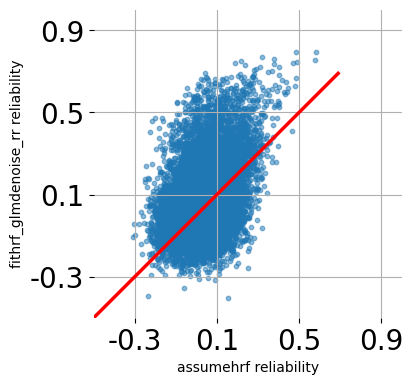

In [69]:
draw_plots = True

if draw_plots: 
    
    x_version = 'assumehrf'
    y_version = 'fithrf_glmdenoise_rr'

    # iterate through datasets
    for ds in datasets:
        for subj in info[ds]['subjs']:

            #x = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][x_version], masks[ds][subj])
            #y = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][y_version], masks[ds][subj])
            x = reliability[ds][subj][x_version]
            y = reliability[ds][subj][y_version]

            #x[masks[ds][subj] < 1] = np.nan
            #y[masks[ds][subj] < 1] = np.nan

            plt.figure(figsize=(4,4))
            plt.grid('on')
            plt.scatter(x, y, 10, alpha = 0.5)
            plt.axis('square')
            plt.xlabel(f"{x_version} reliability")
            plt.ylabel(f"{y_version} reliability")

            plt.plot(np.arange(-0.6,0.7,0.01),np.arange(-0.6,0.7,0.01),'r',linewidth=2.5,zorder=10)

            if ds == 'mindeye':
                ticks = (-0.3,0.8,0.4)
            else:
                ticks = (-0.3,1,0.4)

            plt.xticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
                       np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)
            plt.yticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
                       np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)

            if ds == 'mindeye':
                plt.xlim([-0.5,0.75])
                plt.ylim([-0.5,0.75])
            else:
                plt.xlim([-0.5,1])
                plt.ylim([-0.5,1])

            # get rid of the frame
            for spine in plt.gca().spines.values():
                spine.set_visible(False)

            plt.savefig(f"{figuredir_glmsingle}/scatter.jpg", bbox_inches='tight', dpi=150)  # https://stackoverflow.com/questions/19576317/matplotlib-savefig-does-not-save-axes
            plt.show()

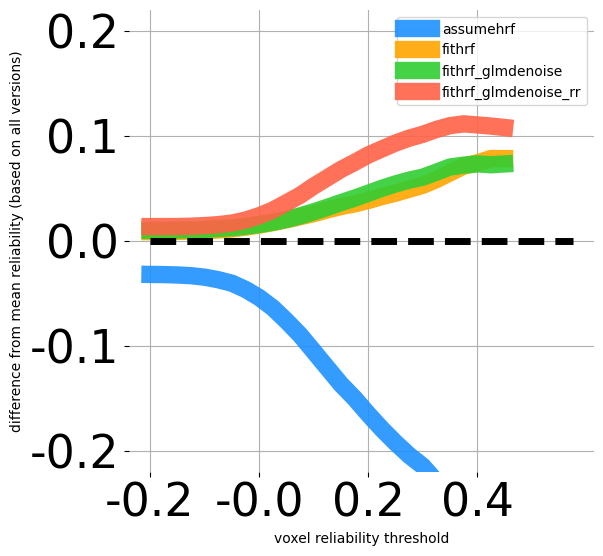

In [70]:
ft = 16

versions = ['assumehrf','fithrf','fithrf_glmdenoise','fithrf_glmdenoise_rr']
colors = ['dodgerblue','orange','limegreen','tomato']

bins  = np.round(np.arange(-0.2,0.6,0.025),3)

method = 'mean'
min_nvox = 100

allsubj_diffs = dict()

# iterate through datasets
for ds in ['v1']:
    
    allsubj_diffs[ds] = dict()
    
    for version in versions:
        allsubj_diffs[ds][version] = []

    # iterate through subjects
    for subj in info[ds]['subjs']:
                
        plt.figure(figsize=(6,6))
        
        subj_mean_metric = reliability[ds][subj]['mean']
        
        subj_version_diffs = []
        
        # iterate through versions
        v=0
        for version in versions:
            
            this_version = reliability[ds][subj][version]
            this_version_diffs = []
            this_version_stds = []
            for val in bins:
           
                validvox = subj_mean_metric > val
                
                if np.sum(validvox) > min_nvox:
                    if method == 'mean':
                        this_version_diffs.append(np.nanmean(this_version[validvox] - subj_mean_metric[validvox]))
                    elif method == 'median':
                        this_version_diffs.append(np.nanmedian(this_version[validvox] - subj_mean_metric[validvox]))
                    this_version_stds.append(np.nanstd(this_version[validvox] - subj_mean_metric[validvox]))
                else:
                    this_version_diffs.append(np.nan)
                    this_version_stds.append(np.nan)
                    
            
            subj_version_diffs.append(this_version_diffs)
            plt.plot(this_version_diffs,linewidth=12.5,color = colors[v],alpha=.9)
            
            v+=1
            
            allsubj_diffs[ds][version].append(this_version_diffs)
                
            
        plt.plot(np.zeros((len(bins),)),'k--',linewidth=5)
        plt.xticks(np.arange(len(bins))[::8],np.array(bins[::8]),fontsize=ft);
        
        plt.yticks(np.round(np.arange(-0.2,0.3,0.1),2),np.round(np.arange(-0.2,0.3,0.1),2),fontsize=33)
        plt.ylim([-0.22,0.22])
      
        plt.xticks(fontsize=33)
        plt.yticks(fontsize=33)
        plt.grid('on')         
        # get rid of the frame
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        plt.xlabel('voxel reliability threshold')
        plt.ylabel('difference from mean reliability (based on all versions)')
        plt.legend(versions)
        plt.savefig(f"{figuredir_glmsingle}/reliability_lineplot.jpg", bbox_inches='tight', dpi=150)
        plt.show()